# Language Modelling (TA: Yash Patel)

The goal of this project is to model city names using character-level language models.


### Distribution (percent)

- Unigram: 15
- Bigram: 15
- Trigram: 15
- Neural N-gram LM: 25
- RNN LM: 30

In [ ]:
STUDENT_SAP_NAME  = "Siddharth Jain"
STUDENT_SR_NUMBER = "24364"

# Read and Preprocess Data

In [ ]:
pip install torch==2.3.0 torchtext==0.18

In [ ]:
# importing necessary libraries
import pandas as pd
import numpy as np
import math

import random
from collections import Counter, defaultdict
from torchtext.vocab import build_vocab_from_iterator
from torch.utils.data import DataLoader

Please note that we may change the contents of the following four files when we rerun your code, so please make sure that your solution is not specifically engineered to just these names.

In [ ]:
# Download the training and validation datasets
!wget -O train_data.csv "https://docs.google.com/spreadsheets/d/11XH5kidyglP-zlP2AjAxfD0Brpu4hmBZP-Uuy9VfjE8/export?format=csv"
!wget -O valid_data.csv "https://docs.google.com/spreadsheets/d/1cxkItpdzz0yWc4Tk_1oA4UO6_oUy2cyF4mW3R1D9G9k/export?format=csv"

# Download the text for evaluation
!wget -O eval_prefixes.txt "https://drive.google.com/uc?export=download&id=1tuRLJXLd2VcDaWENr8JTZMcjFlwyRo60"
!wget -O eval_sequences.txt "https://drive.google.com/uc?export=download&id=1kjPAR04UTKmdtV-FJ9SmDlotkt-IKM3b"

--2025-03-03 15:11:58--  https://docs.google.com/spreadsheets/d/11XH5kidyglP-zlP2AjAxfD0Brpu4hmBZP-Uuy9VfjE8/export?format=csv
Resolving docs.google.com (docs.google.com)... 142.251.18.101, 142.251.18.139, 142.251.18.102, ...
Connecting to docs.google.com (docs.google.com)|142.251.18.101|:443... connected.
HTTP request sent, awaiting response... 307 Temporary Redirect
Location: https://doc-00-14-sheets.googleusercontent.com/export/54bogvaave6cua4cdnls17ksc4/f56vo5bd6roa7qali9iv6hmk7c/1741014715000/118234330873002746631/*/11XH5kidyglP-zlP2AjAxfD0Brpu4hmBZP-Uuy9VfjE8?format=csv [following]
--2025-03-03 15:11:58--  https://doc-00-14-sheets.googleusercontent.com/export/54bogvaave6cua4cdnls17ksc4/f56vo5bd6roa7qali9iv6hmk7c/1741014715000/118234330873002746631/*/11XH5kidyglP-zlP2AjAxfD0Brpu4hmBZP-Uuy9VfjE8?format=csv
Resolving doc-00-14-sheets.googleusercontent.com (doc-00-14-sheets.googleusercontent.com)... 142.251.31.132, 2a00:1450:4013:c1a::84
Connecting to doc-00-14-sheets.googleuserconte

In [ ]:
## Please do not change anything in this code block.

def read_dataframe(ds_type):
    """
    Args:
        ds_type [str] :  dataset type (train or valid)

    Returns:
        df [pandas dataframe]
    """

    df = pd.read_csv(f"/content/{ds_type}_data.csv", header=0)
    print(df)
    df = df[~df['Name'].isna()]
    df['Name'] = df['Name'].astype(str)
    return df

# Load the training and validation datasets
train_data = read_dataframe("train")
validation_data = read_dataframe("valid")

# Read files containing prefixes and character sequences for evaluation
with open('eval_prefixes.txt', 'r') as file:
    eval_prefixes = []
    for line in file:
        eval_prefixes.append(line.strip().split(" "))

with open('eval_sequences.txt', 'r') as file:
    eval_sequences = []
    for line in file:
        eval_sequences.append(line.strip().split(" "))

print(f"Length of training data: {len(train_data)}\nLength of validation data: {len(validation_data)}")

                Name
0             susari
1             belari
2            bandora
3       tummalapenta
4          majhgawan
...              ...
3395     parappukara
3396      morubagalu
3397          dasaut
3398  pullalacheruvu
3399         bhavani

[3400 rows x 1 columns]
            Name
0      enamadala
1     aurangabad
2     mustafabad
3         kalyan
4        kadiyam
...          ...
1129  madhavaram
1130     shahpur
1131     bimawan
1132     jalgaon
1133   virapandi

[1134 rows x 1 columns]
Length of training data: 3400
Length of validation data: 1134


In [ ]:
## Please do not change anything in this code block.

START = "<s>"   # Start-of-name token
END = "</s>"    # End-of-name token
UNK = "<unk>"   # token representing out of unknown (or out of vocabulary) tokens
vocab_from_ascii = False

def build_vocab(names):
    """
    Builds a vocabulary given a list of names

    Args:
        names [list[str]]: list of names

    Returns:
        vocab [torchtext.vocab]: vocabulary based on the names

    """

    if vocab_from_ascii:
        char_counts = {chr(i):i for i in range(128)}
    else:
        char_counts = Counter("".join(names))

    vocab = build_vocab_from_iterator(
                    char_counts,
                    specials=[UNK, START, END], #adding special tokens to the vocabulary
                    min_freq=1
                )
    vocab.set_default_index(vocab[UNK])
    return vocab


def tokenize_name(name):
    """
    Tokenise the name i.e. break a name into list of characters

    Args:
        name [str]: name to be tokenized

    Returns:
        list of characters
    """

    return list(str(name))


def process_data_for_input(data_iter, vocab):
    """
    Processes data for input: Breaks names into characters,
    converts out of vocabulary tokens to UNK and
    appends END token at the end of every name

    Args:
        data_iter: data iterator consisting of names
        vocab: vocabulary

    Returns:
        data_iter [list[list[str]]]: list of names, where each name is a
                                list of characters and is appended with
                                START and END tokens

    """

    vocab_set = set(vocab.get_itos())
    # convert Out Of Vocabulary (OOV) tokens to UNK tokens
    data_iter = [[char if char in vocab_set else UNK
                        for char in tokenize_name(name)] for name in data_iter]
    data_iter = [[START] + name + [END] for name in data_iter]
    return data_iter


def get_tokenised_text_and_vocab(ds_type, vocab=None):
    """
    Reads input data, tokenizes it, builds vocabulary (if unspecified)
    and outputs tokenised list of names (which in turn is a list of characters)

    Args:
        ds_type [str]: Type of the dataset (e.g., train, validation, test)
        vocab [torchtext.vocab]: vocabulary;
                                 If vocab is None, the function will
                                 build the vocabulary from input text.
                                 If vocab is provided, it will tokenize name
                                 according to the vocab, replacing any tokens
                                 not part of the vocab with UNK token.

    Returns:
        data_iter: data iterator for tokenized names
        vocab: vocabulary
    """

    # read the 'Name' column of the dataframe
    if ds_type=='train':
        data_iter = train_data['Name']
    elif ds_type=='valid':
        data_iter = validation_data['Name']
    else:
        data_iter = test_data['Name']

    # build vocab from input data, if vocab is unspecified
    if vocab is None:
        vocab = build_vocab(data_iter)

    # convert OOV chars to UNK, append START and END token to each name
    data_iter = process_data_for_input(data_iter, vocab)

    return data_iter, vocab

Let's look at some examples from the training set

In [ ]:
# Look at some random examples from the training set
examples = ", ".join(random.sample(list(train_data['Name']), 5))
f"Examples from the training set: {examples}"

'Examples from the training set: laligam, pilibangan, barhauna, marjampad, narayanpet'

# Module 1: N-gram Language Modelling

In [ ]:


"""choose your hyperparameter and see the difference in performance"""

# CHANGE THE None VALUES TO YOUR DESIRED VALUES


# BEGIN CODE : stat.namelength

MAX_NAME_LENGTH = 5 # maximum length of names for generation




In [ ]:
# Get data iterator and build vocabulary from input text

train_text, vocab = get_tokenised_text_and_vocab(ds_type='train')
validation_text, _ = get_tokenised_text_and_vocab(ds_type='valid', vocab=vocab)

# Check the size of vocabulary
vocab_size = len(vocab.get_stoi())
print(vocab_size)
print(train_text)

29
[['<s>', 's', 'u', 's', 'a', 'r', 'i', '</s>'], ['<s>', 'b', 'e', 'l', 'a', 'r', 'i', '</s>'], ['<s>', 'b', 'a', 'n', 'd', 'o', 'r', 'a', '</s>'], ['<s>', 't', 'u', 'm', 'm', 'a', 'l', 'a', 'p', 'e', 'n', 't', 'a', '</s>'], ['<s>', 'm', 'a', 'j', 'h', 'g', 'a', 'w', 'a', 'n', '</s>'], ['<s>', 'k', 'a', 'p', 'a', 's', 'i', 'a', 'w', 'a', 'n', '</s>'], ['<s>', 'g', 'u', 'l', 'b', 'a', 'r', 'g', 'a', '</s>'], ['<s>', 't', 'a', 'u', 'l', 'a', 'h', 'a', '</s>'], ['<s>', 'k', 'i', 'r', 'a', 'n', 'u', 'r', '</s>'], ['<s>', 'k', 'h', 'o', 'k', 'h', 'a', '</s>'], ['<s>', 'k', 'a', 'l', 'a', 'd', 'g', 'i', '</s>'], ['<s>', 'm', 'a', 'l', 'l', 'a', 's', 'a', 'm', 'u', 'd', 'r', 'a', 'm', '</s>'], ['<s>', 'b', 'a', 'l', 'v', 'a', 'd', 'i', '</s>'], ['<s>', 'b', 'a', 'g', 'a', 'u', 'r', 'a', '</s>'], ['<s>', 'm', 'a', 'd', 'a', 't', 't', 'u', 'k', 'k', 'u', 'l', 'a', 'm', '</s>'], ['<s>', 's', 'i', 'l', 'a', 'd', 'o', 'n', '</s>'], ['<s>', 'c', 'h', 'a', 'r', 'i', 'p', 'a', 'r', 'a', '</s>'], ['

In [ ]:
print(vocab.get_itos())

['<unk>', '<s>', '</s>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


Now it's time to implement an [n-gram language model](https://web.stanford.edu/~jurafsky/slp3/3.pdf).

One edge case you will need to handle is that you don't have $n-1$ prior characters at the beginning of the text.  One way to do this is by appending the `START` token $n-1$ times at the start of the name, when implementing an $n$-gram model. You may choose whichever method you like to handle this case as long as you produce a valid probability distribution (one that sums to one).

**Generating names**

To generate from a language model, we can sample one char at a time conditioning on the chars we have generated so far.

In fact there are many strategies to get better-sounding samples, such as only sampling from the top-k chars or sharpening the distribution with a temperature.  You can read more about sampling from a language model in [this](https://arxiv.org/pdf/1904.09751.pdf) paper.


We will now implement N-gram models with $N=1$ (unigram), $N=2$ (bigram), and $N=3$ (trigram).

**Utility Functions**

Implement the utility functions `get_unigram_counts`, `get_bigram_counts` and `get_trigram_counts`. You can use these functions while implementing n-gram models.

In [ ]:

def get_unigram_counts(corpus):
    """
    Given a corpus, calculates the unigram counts for each character in the corpus

    Args:
        corpus [list[list[str]]]: list of tokenized characters. Text is appended with END token.

    Returns:
        unigram_counts [dict [key: char, value: count]]:
            dictionary of unigram counts for each character in the corpus
        Example:
        > unigram_counts["c1"] = 5
    """

    
    # BEGIN CODE : unigram_count.get_unigram_counts
    unigram_counts = defaultdict(int)

    for names in corpus:
      names = [START] + names

    for names in corpus:
      for letters in names:
        #if letters not in [END]:
        unigram_counts[letters] += 1

    

    return unigram_counts



In [ ]:

def get_bigram_counts(corpus):
    """
    Given a corpus, calculates the bigram counts for each bigram in the corpus.
    The corpus *only* contains END tokens at the end of names.
    You may want to handle the case whhere beginning of the name
    does not have n-1 prior chars.

    Args:
        corpus [list[list[str]]]: list of tokenized text. Text is appended with END token.

    Returns:
        bigram_counts [dict[dict]]:
            nested dictionary of bigram counts for each bigram in the corpus
        Example:
        > bigram_counts["c1"]["c2"] = 5
        here bigram_counts["c1"]["c2"] represents P("c2"|"c1")
        P["c1"]["c2"] means P[char_i = "c2"|char_{i-1} = "c1"]
    """

    
    # BEGIN CODE : bigram_counts.get_bigram_counts
    bigram_counts = defaultdict(lambda: defaultdict(int))

    for names in corpus:
        names = [START] + names

    for names in corpus:
      for i in range(len(names)-1):
        letter_one = names[i]
        letter_plus_one = names[i+1]
        #if letter_plus_one not in [END]:
        bigram_counts[letter_one][letter_plus_one] += 1

    

    return bigram_counts



In [ ]:

def get_trigram_counts(corpus):
    """
    Given a corpus, calculates the trigram counts for each trigram in the corpus.
    The corpus *only* contains END tokens at the end of names.
    You may want to handle the case where beginning of the text
    does not have n-1 prior chars.

    Args:
        corpus [list[list[str]]]: list of tokenized text. Text is appended with END token.

    Returns:
        trigram_counts [dict[dict[dict]]]:
            nested dictionary for each trigram in the corpus
        Example:
        > trigram_counts["c1"]["c2"]["c3"] = 5
        P["c1"]["c2"]["c3] means P[char_i = "c3"|char_{i-2} = "c1", char_{i-1} = "c2"]

    """

    
    # BEGIN CODE : trigram_counts.get_trigram_counts
    trigram_counts = defaultdict(lambda: defaultdict(lambda: defaultdict(int)))

    for names in corpus:
      if names[0] != START and names[1] != START:
        names = [START, START] + names
      if names[0] == START and names[1] != START:
        names = [START] + names

    for names in corpus:
      for i in range(len(names)-2):
        letter_one = names[i]
        letter_plus_one = names[i+1]
        letter_plus_two = names[i+2]
        #if letter_plus_two not in [END]:
        trigram_counts[letter_one][letter_plus_one][letter_plus_two]  += 1


    

    return trigram_counts



In [ ]:
print(get_trigram_counts(train_text))

defaultdict(<function get_trigram_counts.<locals>.<lambda> at 0x7fbc34cc6ca0>, {'<s>': defaultdict(<function get_trigram_counts.<locals>.<lambda>.<locals>.<lambda> at 0x7fbc34cc7a60>, {'s': defaultdict(<class 'int'>, {'u': 39, 'i': 59, 'a': 115, 'h': 42, 'e': 15, 'o': 21, 'r': 7, 'w': 2}), 'b': defaultdict(<class 'int'>, {'e': 27, 'a': 155, 'i': 45, 'r': 4, 'h': 54, 'u': 14, 'y': 2, 'o': 15}), 't': defaultdict(<class 'int'>, {'u': 20, 'a': 48, 'i': 53, 'e': 20, 'r': 7, 'h': 13, 'o': 6, 's': 1, 'y': 2}), 'm': defaultdict(<class 'int'>, {'a': 203, 'o': 17, 'u': 58, 'e': 20, 'i': 12}), 'k': defaultdict(<class 'int'>, {'a': 215, 'i': 23, 'h': 60, 'o': 109, 'u': 70, 'e': 15, 'r': 4}), 'g': defaultdict(<class 'int'>, {'u': 35, 'h': 15, 'o': 26, 'a': 47, 'e': 1, 'i': 2, 'w': 1}), 'c': defaultdict(<class 'int'>, {'h': 149, 'u': 3, 'o': 5}), 'v': defaultdict(<class 'int'>, {'e': 46, 'a': 60, 'o': 3, 'i': 29, 'u': 3, 'r': 1}), 'e': defaultdict(<class 'int'>, {'r': 17, 'l': 11, 'd': 7, 's': 1, 'k

In [ ]:
"""
Implementation of the n-gram language models.
All other n-gram models (unigram, bigram, etc.) would follow the same skeleton.
"""

class NGramLanguageModel(object):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names

        Returns:
            -
        """
        return

    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:
                for N=1 (unigram); dict[key:unigram,value:probability of unigram]
                    > P["c1"] = 0.0001
                for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["c1"]["c2"] = 0.0001
                    P["c1"]["c2"] means P["c2"|"c1"]
                for N=3 (trigram); dict[dict[dict]]
                    > P["c1"]["c2"]["c3"] = 0.0001
                    P["c1"]["c2"]["c3] means P[char_i = "c3"|char_{i-2} = "c1", char_{i-1} = "c2"]
        """

        return


    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the language model

        Args:
            name [list]: list of tokens

        Returns:
            log_prob [float]: Log probability of the given name
        """
        return 0.0


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity [float]: perplexity of the given text
        """
        return 0.0


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.
        You may stop the generation when n tokens have been generated,
        or when you encounter the END token.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            names [list[str]]: list of generated names
        """
        return []

    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        return []

    def get_position_specific_probabilities(self, max_position=5):
        """
        Compute character probability distributions for each position in names.

        This function provides methods to compute position specific character probability distributions based on unigram,
        bigram, and trigram models.

        The following probability distributions are implemented:
        - **Unigram Model**: P(char | position) → Probability of a character appearing at a given position.
        - **Bigram Model**: P(current_char | prev_char) → Probability of a character given the previous one.
        - **Trigram Model**: P(current_char | prev_char1, prev_char2) → Probability of a character given the last two.

        **Key Functions:** For specific details and examples, refer to the respective functions in each model class for Unigram, Bigram and Trigram.
        - `get_position_specific_probabilities()`: Computes probability distributions.
          - **Unigram**: P(char | position) → See `UnigramModel.get_position_specific_probabilities()`
          - **Bigram**: P(current_char | prev_char) → See `BigramModel.get_position_specific_probabilities()`
          - **Trigram**: P(current_char | prev_char1, prev_char2) → See `TrigramModel.get_position_specific_probabilities()`

        """

        return []

In [ ]:
# ## Please do not change anything in this code block.

def check_validity(model, ngram, is_neural):
    """
    Checks if get_next_char_probabilities returns a valid probability distribution
    """

    if ngram==1 or is_neural:
        P = model.get_next_char_probabilities()
        is_valid = validate_probability_distribution(P.values())
        if not is_valid:
            return is_valid

    elif ngram==2:
        P = model.get_next_char_probabilities()
        for char1 in P.keys():
            is_valid = validate_probability_distribution(list(P[char1].values()))
            if not is_valid:
                return is_valid

    elif ngram==3:
        P = model.get_next_char_probabilities()
        for char1 in P.keys():
            for char2 in P[char1].keys():
                is_valid = validate_probability_distribution(list(P[char1][char2].values()))
                if not is_valid:
                    return is_valid
    else:
        print("Enter a valid number for ngram")

    return True


def validate_probability_distribution(probs):
    """
    Checks if probs is a valid probability distribution
    """
    if not min(probs) >= 0:
        print("Negative value in probabilities")
        return False
    elif not max(probs) <= 1 + 1e-8:
        print("Value larger than 1 in probabilities")
        return False
    elif not abs(sum(probs)-1) < 1e-4:
        print("probabilities do not sum to 1")
        return False
    return True

def check_validity_of_position_specific_probability(model, ngram, is_neural):
    """
    Checks if get_next_char_probabilities returns a valid probability distribution
    """

    if ngram==1:
        position_distributions = model.get_position_specific_probabilities()
        valid_count = 0
        total_positions = len(position_distributions)

        for pos, char_probs in enumerate(position_distributions, start=1):
            total_prob = sum(char_probs.values())
            if 0.99 <= total_prob <= 1.01:
                valid_count += 1
        return valid_count

    elif ngram==2 or ngram==3:
        position_distributions = model.get_position_specific_probabilities()
        valid_count = 0
        total_positions = len(position_distributions)
        for pos, dist in enumerate(position_distributions, start=1):
            if not dist:
                print(f"Validation Failed at Position {pos}! No distributions found.")
                continue
            position_valid = True
            for prev_char, next_char_probs in dist.items():
                total_prob = sum(next_char_probs.values())
                if not (0.99 <= total_prob <= 1.01):
                    position_valid = False
            if position_valid:
                valid_count += 1
        return valid_count

    else:
        print("Enter a valid number for ngram")

    return True

def eval_ngram_model(model, n, ngram, ds, ds_name, eval_prefixes, eval_sequences, num_names=5, is_neural=False):
    """
    Runs evaluations on n-gram models with beam search support
    """
    # (1) Check probability distribution validity
    is_valid = check_validity(model=model, ngram=ngram, is_neural=is_neural)
    print(f'EVALUATION probability distribution is valid: {is_valid}')

    # (2) Check position specific probability distribution validity
    if not is_neural:
        valid_count = check_validity_of_position_specific_probability(model=model, ngram=ngram, is_neural=is_neural)
        print(f'Total positions which have valid probability distributions: {valid_count}')

    # (3) Evaluate perplexity
    print(f'EVALUATION of {ngram}-gram on {ds_name} perplexity:',
          model.get_perplexity(ds))

    # (4) Generate top-k names using beam search
    generated_names = ", ".join(model.generate_names(n=n,k=num_names))
    print(f'EVALUATION {ngram}-gram TOP {num_names} names: {generated_names}')

    # (5) Generate names with prefixes
    for prefix in eval_prefixes:
        generated_names_with_prefix = ", ".join(model.generate_names(n=n, k=num_names, prefix=prefix))
        prefix_str = ''.join(prefix)
        print(f'EVALUATION {ngram}-gram TOP {num_names} names with prefix "{prefix_str}": {generated_names_with_prefix}')

    # (6) Get most likely characters
    for sequence in eval_sequences:
        most_likely_chars = ", ".join(model.get_most_likely_chars(sequence=sequence, k=num_names))
        sequence_str = "".join(sequence)
        print(f"EVALUATION {ngram}-gram top likely chars after '{sequence_str}': {most_likely_chars}")

    # (7) Check KL divergence for unigram
    if ngram==1:
        position_distributions = model.get_position_specific_probabilities(max_position=5)
        position_1_dist = position_distributions[0]
        position_2_dist = position_distributions[1]
        kl_div = model.calculate_kl_divergence_between_positions(position_1_dist, position_2_dist)
        print(f'KL Divergence between position 1 and 2 is: {kl_div:.3f}')



## 1.1 Unigram

In [ ]:

"""
Implementaion of a Unigram Model without smoothing
"""

class UnigramModel(NGramLanguageModel):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names
        """

        
        # BEGIN CODE : unigrammodel.init
        self.train_text_copy = train_text
        self.text_length = len(self.train_text_copy)
        self.count_dict = get_unigram_counts(self.train_text_copy)
        self.total_words = 0
        for names in train_text:
          self.total_words += len(names)

        


    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary

        Returns:
            key: char, value: probability
        """
        
        # BEGIN CODE : unigrammodel.get_next_char_prob
        next_char_probabilities = defaultdict(float)
        for k,v in self.count_dict.items():
          next_char_probabilities[k] = v/self.total_words

        

        return next_char_probabilities


    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        
        # BEGIN CODE : unigrammodel.get_name_log_prob
        name_log_probability = 0


        next_char_probab = self.get_next_char_probabilities()

        for ch in name:
          char_prob = next_char_probab.get(ch, 1e-10)
          name_log_probability += math.log(char_prob)

        

        return name_log_probability


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity of the given text [float]
        """

        
        # BEGIN CODE : unigrammodel.get_perplexity

        if isinstance(text[0], list):
          log_prob = sum(self.get_name_log_probability(name) for name in text)
          txt_len = sum(len(name) for name in text)
        else:
          log_prob = self.get_name_log_probability(text)
          txt_len = len(text)

        perplexity = math.exp(-log_prob/txt_len)

        

        return perplexity


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list]
        """

        
        # BEGIN CODE : unigrammodel.generate_names

        generated_names = []
        next_char_prob = self.get_next_char_probabilities()
        c = 0
        l = 0
        if (prefix != None):
          p = 0
          l = len(prefix)
          while(prefix[p] == START):
            c += 1
            p += 1

        t = n - l + c
        #prefix_len = len(prefix) if prefix != None else 0


        text_letter = [char for char in next_char_prob.keys() if char != START]
        prob_letters = [next_char_prob[char] for char in text_letter]

        for i in range(k):
          name_generated = list(prefix) if prefix is not None else []
          for j in range(t):
            next_char = random.choices(text_letter, weights = prob_letters,k = 10)[0]
            if next_char == END:
              break
            name_generated.append(next_char)
          generated_names.append(''.join(name_generated))

        

        return generated_names


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        
        # BEGIN CODE : unigrammodel.get_most_likely_chars
        most_likely_chars = []
        next_char_prob = self.get_next_char_probabilities()
        sorted_prob = sorted(next_char_prob.items(), key=lambda x: x[1], reverse=True)
        most_likely_chars = [char for char, prob in sorted_prob[:k] if (char != START and char != END)]

        

        return most_likely_chars


    def get_position_specific_probabilities(self, max_position=5):
        """
        Computes probability distributions for each character in the vocabulary at specific positions in words.

        This method analyzes the training data to calculate the likelihood of each character appearing
        at different positions (1st, 2nd, 3rd, etc.) in words. For example, it determines how often
        'q' appears as the first letter, second letter, and so on.

        Args:
            max_position (int, optional): Maximum number of initial positions in words to analyze.
                For example, if max_position=3, only the first three positions in words will be
                considered. Defaults to 5.

        Returns:
            list[dict]: A list of dictionaries where:
                - The index represents the position (0-based)
                - Each dictionary maps characters to their probabilities at that position
                - Example: [{'a': 0.1, 'b': 0.2, ...}, {'a': 0.15, 'b': 0.1, ...}, ...]
                - The probabilities in each dictionary sum to 1.0

        Example:
            >>> model.get_position_specific_probabilities(2)
            [
                {'a': 0.12, 'b': 0.08, 'c': 0.15, ...},  # Probabilities for first position
                {'a': 0.40, 'b': 0.11, 'c': 0.07, ...}   # Probabilities for second position
            ]
        """

        
        # BEGIN CODE : unigrammodel.get_position_specific_prob
        position_distributions = [defaultdict(float) for _ in range(max_position)]
        all_char = set()

        for word in self.train_text_copy:
          for position in range(min(max_position, len(word))):
            all_char.add(word[position])

        for position in range(max_position):
          for ch in all_char:
            position_distributions[position][ch] = 0.0

        for word in self.train_text_copy:
          if isinstance(word, str):
            word = list(word)
          for pos in range(min(len(word) - 1, max_position)):
            char = word[pos + 1]
            position_distributions[pos][char] += 1

        for pos in range(max_position):
          t_count = sum(position_distributions[pos].values())
          if t_count > 0:
            position_distributions[pos] = {
                    char: count / t_count
                    for char, count in position_distributions[pos].items()}

        

        return position_distributions


    def calculate_kl_divergence_between_positions(self, p, q):
        """
        Computes overall KL divergence between two probability distributions.

        Args:
            p [dict]: Probability distribution
            q [dict]: Probability distribution

        Returns:
            kl_divergence [float]: KL(p||q). Returns -1 if the KL divergence is undefined.
        """

        
        # BEGIN CODE : unigrammodel.kl_divergence
        p_l = len(p)
        q_l = len(q)
        kl_div = 0.0

        if not p or not q or p!=q:
            return -1
        for k,v in p.items():
          if p[k] != 0 and q[k]!=0:
            kl_div += v*(math.log(p[k])-math.log(q[k]))
          else:
            return -1

        

        return kl_div



### Eval

**Note**: For models without smoothing, you may observe perplexity as `inf` if the validation or test set contains characters not seen in the train set
However, this should not happen for models where you implement smoothing.

In [ ]:
## Please do not change anything in this code block.

unigram_model = UnigramModel(train_text)

# Check the perplexity of the unigram model on the train set
print('unigram train perplexity:', unigram_model.get_perplexity(train_text))

unigram train perplexity: 17.371830431823533


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=unigram_model, n = MAX_NAME_LENGTH, ngram=1, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
Total positions which have valid probability distributions: 5
EVALUATION of 1-gram on validation perplexity: 17.38669842565595
EVALUATION 1-gram TOP 5 names: , imuia, taaan, t, yfmed
EVALUATION 1-gram TOP 5 names with prefix "<s><s>sh": <s><s>shlh, <s><s>shing, <s><s>shuka, <s><s>shguk, <s><s>shlrg
EVALUATION 1-gram TOP 5 names with prefix "<s><s>na": <s><s>narrk, <s><s>namn, <s><s>nakai, <s><s>naurr, <s><s>naara
EVALUATION 1-gram TOP 5 names with prefix "<s><s>da": <s><s>dao, <s><s>dalaa, <s><s>daphe, <s><s>danph, <s><s>daibp
EVALUATION 1-gram TOP 5 names with prefix "<s><s>ki": <s><s>kiuan, <s><s>kinat, <s><s>kiaan, <s><s>kiaau, <s><s>kiapa
EVALUATION 1-gram TOP 5 names with prefix "<s><s>ra": <s><s>ra, <s><s>raacc, <s><s>rakun, <s><s>raoog, <s><s>ratka
EVALUATION 1-gram TOP 5 names with prefix "<s><s>de": <s><s>denmn, <s><s>deuhh, <s><s>de, <s><s>deign, <s><s>delgh
EVALUATION 1-gram TOP 5 names with prefix "<s><s>ni": <s><s>nirra, <

In [ ]:
## Please do not change anything in this code block.
position_distributions = unigram_model.get_position_specific_probabilities(max_position=5)

print("Position-Specific Probabilities:")
for pos, dist in enumerate(position_distributions, start=1):
    # Sort dictionary by character key (a-z, A-Z)
    sorted_dist = {k: round(v, 2) for k, v in sorted(dist.items())}  # Round to 2 decimal places
    print(f"Position {pos}: {sorted_dist}")

Position-Specific Probabilities:
Position 1: {'<s>': 0.0, 'a': 0.06, 'b': 0.09, 'c': 0.05, 'd': 0.04, 'e': 0.01, 'f': 0.0, 'g': 0.04, 'h': 0.03, 'i': 0.01, 'j': 0.03, 'k': 0.15, 'l': 0.01, 'm': 0.09, 'n': 0.05, 'o': 0.01, 'p': 0.1, 'q': 0.0, 'r': 0.04, 's': 0.09, 't': 0.05, 'u': 0.01, 'v': 0.04, 'w': 0.0, 'x': 0.0, 'y': 0.01, 'z': 0.0}
Position 2: {'<s>': 0.0, 'a': 0.43, 'b': 0.0, 'c': 0.0, 'd': 0.01, 'e': 0.08, 'f': 0.0, 'g': 0.0, 'h': 0.12, 'i': 0.09, 'j': 0.0, 'k': 0.0, 'l': 0.01, 'm': 0.01, 'n': 0.01, 'o': 0.08, 'p': 0.0, 'q': 0.0, 'r': 0.02, 's': 0.01, 't': 0.01, 'u': 0.1, 'v': 0.0, 'w': 0.0, 'x': 0.0, 'y': 0.0, 'z': 0.0}
Position 3: {'<s>': 0.0, 'a': 0.1, 'b': 0.01, 'c': 0.01, 'd': 0.07, 'e': 0.01, 'f': 0.0, 'g': 0.02, 'h': 0.03, 'i': 0.06, 'j': 0.01, 'k': 0.03, 'l': 0.11, 'm': 0.05, 'n': 0.13, 'o': 0.01, 'p': 0.01, 'q': 0.0, 'r': 0.14, 's': 0.03, 't': 0.07, 'u': 0.02, 'v': 0.01, 'w': 0.01, 'x': 0.0, 'y': 0.01, 'z': 0.01}
Position 4: {'<s>': 0.0, 'a': 0.25, 'b': 0.02, 'c': 0.01, 

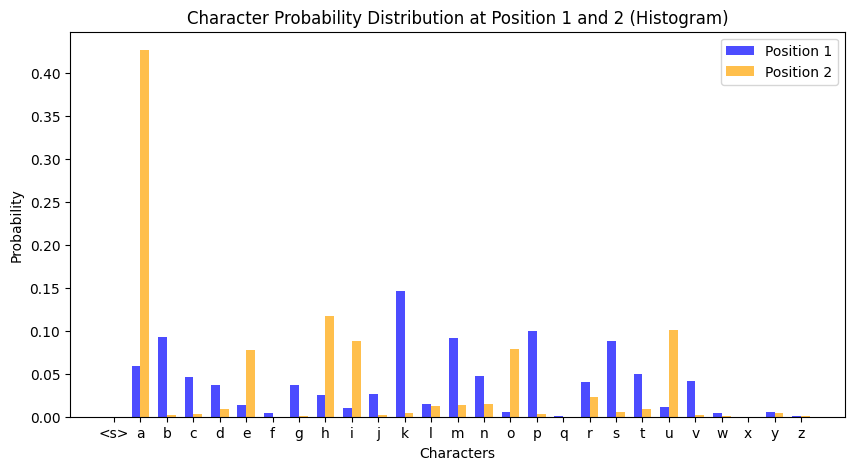

In [ ]:
## Please do not change anything in this code block.
import matplotlib.pyplot as plt
import numpy as np

position_1_distribution = position_distributions[0]
position_2_distribution = position_distributions[1]

sorted_chars = sorted(position_1_distribution.keys())

probs_pos1 = [position_1_distribution[char] for char in sorted_chars]
probs_pos2 = [position_2_distribution[char] for char in sorted_chars]

spacing_factor = 1.5
x = np.arange(len(sorted_chars)) * spacing_factor
width = 0.5

plt.figure(figsize=(10, 5))
plt.bar(x - width/2, probs_pos1, width=width, label="Position 1", color="blue", alpha=0.7)
plt.bar(x + width/2, probs_pos2, width=width, label="Position 2", color="orange", alpha=0.7)
plt.xlabel("Characters")
plt.ylabel("Probability")
plt.title("Character Probability Distribution at Position 1 and 2 (Histogram)")
plt.xticks(ticks=x, labels=sorted_chars)
plt.legend()
plt.show()

### Smoothing

Implement a smoothed version of the unigram model. You may extend the `UnigramModel` class and re-use some of the functions.  For unigram model, you should implement Add-1 smoothing.

You may refer to the lecture slides or [3.5 Smoothing](https://web.stanford.edu/~jurafsky/slp3/3.pdf) for details on different smoothing technqiues.

In [ ]:

"""
Implementation of unigram model with Add-1 smoothing.

"""
class SmoothedUnigramModel(UnigramModel):

    def __init__(self, train_text):
        super().__init__(train_text)

    '''You should override ONLY those functions which calculate probability of a unigram.
      You can override get_next_char_probabilities or any other helper functions you use in UnigramModel to calculate unigram probabilities.
      Implement Laplace or Add-1 smoothing for the unigram model '''

    
    # BEGIN CODE : smoothing.smoothunigram

    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary

        Returns:
            key: char, value: probability
        """

        next_char_probabilities_withs = defaultdict(float)
        for k,v in self.count_dict.items():
          if v != 0:
            next_char_probabilities_withs[k] = (v+1)/(self.total_words+len(self.count_dict))
          else:
            next_char_probabilities_withs[k] = 1/(sum(self.count_dict.values()) + len(self.count_dict))

        next_char_probabilities = next_char_probabilities_withs
        return next_char_probabilities




    def get_position_specific_probabilities(self, max_position=5):
      """
      Computes probability distributions for each character in the vocabulary at specific positions in words.

      This method analyzes the training data to calculate the likelihood of each character appearing
      at different positions (1st, 2nd, 3rd, etc.) in words. For example, it determines how often
      'q' appears as the first letter, second letter, and so on.

      Args:
          max_position (int, optional): Maximum number of initial positions in words to analyze.
              For example, if max_position=3, only the first three positions in words will be
              considered. Defaults to 5.

      Returns:
          list[dict]: A list of dictionaries where:
              - The index represents the position (0-based)
              - Each dictionary maps characters to their probabilities at that position
              - Example: [{'a': 0.1, 'b': 0.2, ...}, {'a': 0.15, 'b': 0.1, ...}, ...]
              - The probabilities in each dictionary sum to 1.0

      Example:
          >>> model.get_position_specific_probabilities(2)
          [
              {'a': 0.12, 'b': 0.08, 'c': 0.15, ...},  # Probabilities for first position
              {'a': 0.40, 'b': 0.11, 'c': 0.07, ...}   # Probabilities for second position
          ]
      """
      position_distributions = [defaultdict(float) for _ in range(max_position)]
      all_char = set()

      for word in self.train_text_copy:
        for position in range(min(max_position, len(word))):
          all_char.add(word[position])

      for word in self.train_text_copy:
        for pos in range(min(len(word) - 1, max_position)):
          char = word[pos + 1]
          position_distributions[pos][char] += 1

      for pos in range(max_position):
        t_count = sum(position_distributions[pos].values())
        if t_count > 0:
          position_distributions[pos] = {
                  char: count / t_count
                  for char, count in position_distributions[pos].items()}


      return position_distributions

    def calculate_kl_divergence_between_positions(self, p, q):
        """
        Computes overall KL divergence between two probability distributions.

        Args:
            p [dict]: Probability distribution
            q [dict]: Probability distribution

        Returns:
            kl_divergence [float]: KL(p||q). Returns -1 if the KL divergence is undefined.
        """

        
        # BEGIN CODE : unigrammodel.kl_divergence
        p_l = len(p)
        q_l = len(q)
        kl_div = 0.0

        if not p or not q:# or p!=q:
            return -1
        for k,v in p.items():
          q_k = q.get(k, 1e-10)
          if p[k]>0 and q_k>0:
            kl_div += v*(math.log(p[k])-math.log(q_k))
          else:
            return -1

        

        return kl_div

    



In [ ]:
## Please do not change anything in this code block.

smoothed_unigram_model = SmoothedUnigramModel(train_text)

# Check the perplexity of the smoothed unigram model on the train set
print('smoothed unigram train perplexity:',
      smoothed_unigram_model.get_perplexity(train_text))

smoothed unigram train perplexity: 17.372025402651616


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=smoothed_unigram_model, n = MAX_NAME_LENGTH, ngram=1, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences,  num_names=5)

EVALUATION probability distribution is valid: True
Total positions which have valid probability distributions: 5
EVALUATION of 1-gram on validation perplexity: 17.386606261179438
EVALUATION 1-gram TOP 5 names: pmbsr, , z, aguns, 
EVALUATION 1-gram TOP 5 names with prefix "<s><s>sh": <s><s>shakr, <s><s>shadp, <s><s>shliv, <s><s>shuam, <s><s>shukh
EVALUATION 1-gram TOP 5 names with prefix "<s><s>na": <s><s>napia, <s><s>nalu, <s><s>naael, <s><s>nayh, <s><s>naera
EVALUATION 1-gram TOP 5 names with prefix "<s><s>da": <s><s>daagt, <s><s>daurm, <s><s>dagik, <s><s>daatu, <s><s>daan
EVALUATION 1-gram TOP 5 names with prefix "<s><s>ki": <s><s>kiubn, <s><s>kia, <s><s>kispt, <s><s>kikli, <s><s>kind
EVALUATION 1-gram TOP 5 names with prefix "<s><s>ra": <s><s>radar, <s><s>raaaa, <s><s>ratag, <s><s>rahdb, <s><s>raa
EVALUATION 1-gram TOP 5 names with prefix "<s><s>de": <s><s>devan, <s><s>de, <s><s>denon, <s><s>deajp, <s><s>derit
EVALUATION 1-gram TOP 5 names with prefix "<s><s>ni": <s><s>ni, <s><s>nia

In [ ]:
# Release models we don't need any more.
del unigram_model
del smoothed_unigram_model

## 1.2 Bigram


In [ ]:

"""
Implementation of a Bigram Model.
"""

class BigramModel(NGramLanguageModel):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names
        """

        
        # BEGIN CODE : bigram.init
        self.train_text_copy = train_text
        self.text_length = len(self.train_text_copy)
        self.bigram_count_dict = get_bigram_counts(self.train_text_copy)
        self.unigram_count_dict = get_unigram_counts(self.train_text_copy)



        

    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:
                for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["a"]["b"] = 0.0001 (which stands of P("b"|"a"))
        """

        
        # BEGIN CODE : bigram.get_next_char_prob
        next_char_probabilities = defaultdict(lambda: defaultdict(float))

        for k_one, d_two in self.bigram_count_dict.items():
          for k_two, v_two in d_two.items():
            next_char_probabilities[k_one][k_two] = v_two/self.unigram_count_dict[k_one]

        return next_char_probabilities


    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model.
        Be careful with cases for which probability of the name is zero.

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        
        # BEGIN CODE : bigram.get_name_log_prob
        name_log_probability = 0
        next_char_probab = self.get_next_char_probabilities()

        for i in range(len(name)-1):
          char_one = name[i]
          char_two = name[i+1]
          char_prob = next_char_probab.get(char_one, 1e-10).get(char_two, 1e-10)
          name_log_probability += math.log(char_prob)

        

        return name_log_probability


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity of the given text [float]
        """

        
        # BEGIN CODE : bigram.get_perplexity

        if isinstance(text[0], list):
          log_prob = sum(self.get_name_log_probability(name) for name in text)
          txt_len = sum(len(name) for name in text)
        else:
          log_prob = self.get_name_log_probability(text)
          txt_len = len(text)

        perplexity = math.exp(-log_prob/txt_len)


        

        return perplexity


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list]
        """

        
        # BEGIN CODE : bigram.generate_names

        next_char_prob = self.get_next_char_probabilities()
        names = []
        top_k =3
        c = 0
        l = 0
        if (prefix != None):
          p = 0
          l = len(prefix)
          while(prefix[p] == START):
            c += 1
            p += 1

        t = n - l + c

        for _ in range(k):
            name_generated = list(prefix) if prefix else [START]
            last_char = name_generated[-1]

            for _ in range(t):
                if last_char not in next_char_prob:
                    break

                candidate_dict = next_char_prob[last_char]
                candidate_list = list(candidate_dict.items())
                candidate_list.sort(key=lambda x: x[1], reverse=True)
                candidate_list = candidate_list[:top_k] if len(candidate_list) >= top_k else candidate_list
                candidates, candidate_probs = zip(*candidate_list)
                next_char = random.choices(candidates, weights=candidate_probs, k=1)[0]

                if next_char is None or next_char == END:
                    break

                name_generated.append(next_char)
                last_char = next_char

            names.append(''.join(name_generated[1:]))


        

        return names


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        
        # BEGIN CODE : bigram.get_most_likely_chars

        most_likely_chars = []
        next_char_prob = self.get_next_char_probabilities()

        if not sequence:
            return most_likely_chars

        last_char = sequence[-1]

        if last_char in next_char_prob:
            sorted_prob = sorted(
                next_char_prob[last_char].items(), key=lambda x: x[1], reverse=True
            )

            most_likely_chars = [
                char for char, prob in sorted_prob[:k] if char != START and char != END
            ]


        

        return most_likely_chars

    def get_position_specific_probabilities(self, max_position=5):
        """
        Computes conditional probability distributions P(current_char | prev_char) for each position in words.

        This method analyzes character sequences in the training data to calculate position-specific
        transition probabilities between consecutive characters (bigrams). For each position, it computes
        the probability of seeing a character given the previous character, only including previous characters
        that actually occur at the respective positions in the training data.

        Args:
            max_position (int, optional): Maximum number of positions to analyze, starting from position 1.
                For example, if max_position=3, computes probabilities for positions 1, 2, and 3.
                Defaults to 5.

        Returns:
            list[dict]: A list of nested dictionaries where:
                - Index i contains transitions for position i+1
                - Outer dictionary keys are previous characters that occur at position i
                - Inner dictionary keys are current characters with their conditional probabilities
                - Format: [{prev_char: {current_char: probability}}]
                - All probabilities for a given prev_char sum to 1.0

        Character Handling:
            - All characters in vocabulary including special tokens (<s>, </s>, <UNK>)
            - Only include previous characters that actually occur at the respective positions
            - First position always includes '<s>' as previous character

        Example:
            >>> model.get_position_specific_probabilities(2)
            [
                {
                    '<s>': {'a': 0.3, 'b': 0.1, 'c': 0.2, 'd': 0.05, 'e': 0.1, ...}     # Position 1
                    # Only <s> as it's the only valid previous character for first position
                },
                {
                    'a': {'a': 0.05, 'b': 0.1, 'c': 0.2, 'd': 0.09, 'e': 0.15, 'f': 0.1, ...},      # Position 2
                    'b': {'a': 0.2, 'b': 0.04, 'c': 0.2, 'd': 0.05, 'e': 0.05, 'f': 0.2, ...}, ...
                    # Note: 'x' not included as a previous character key if it never appears at position 1
                }
            ]

        Note:
            - Only include previous characters that actually occur at the respective positions in training data
            - A character 'x' should only be included as a key if it appears at the correct position
              in the training data (e.g., position 1 for predicting position 2)
            - Probabilities are computed from training data frequencies
            - Each inner dictionary should contain probabilities for all possible next characters
            - The sum of probabilities for each valid prev_char should equal 1.0
        """


        
        # BEGIN CODE : bigram.get_position_specific_probabilities
        position_distributions = [defaultdict(lambda: defaultdict(float)) for _ in range(max_position)]

        for word in self.train_text_copy:

            for pos in range(min(len(word) - 1, max_position)):
                prev_char = word[pos]
                curr_char = word[pos + 1]

                if pos == 0:
                    if prev_char == START:
                        position_distributions[pos][prev_char][curr_char] += 1
                else:
                    position_distributions[pos][prev_char][curr_char] += 1

        for pos in range(max_position):
            for prev_char, char_counts in position_distributions[pos].items():
                total_count = sum(char_counts.values())
                if total_count > 0:
                    position_distributions[pos][prev_char] = {
                        curr_char: count / total_count
                        for curr_char, count in char_counts.items()
                    }


        
        return position_distributions



### Eval

In [ ]:
## Please do not change anything in this code block.

bigram_model = BigramModel(train_text)

# check the perplexity of the bigram model on training data
print('bigram train perplexity:',
      bigram_model.get_perplexity(train_text))

bigram train perplexity: 7.521916660166419


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=bigram_model, n = MAX_NAME_LENGTH, ngram=2, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
Total positions which have valid probability distributions: 5
EVALUATION of 2-gram on validation perplexity: 8.015776758332018
EVALUATION 2-gram TOP 5 names: kur, punan, panal, pural, panar
EVALUATION 2-gram TOP 5 names with prefix "<s><s>sh": <s>shar, <s>shura, <s>shang, <s>shi, <s>shand
EVALUATION 2-gram TOP 5 names with prefix "<s><s>na": <s>nanan, <s>nar, <s>nalan, <s>nanar, <s>narar
EVALUATION 2-gram TOP 5 names with prefix "<s><s>da": <s>danda, <s>dalan, <s>danga, <s>danal, <s>dari
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ki": <s>ki, <s>kir, <s>kir, <s>ki, <s>ki
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ra": <s>ralar, <s>randa, <s>rarar, <s>rangh, <s>randi
EVALUATION 2-gram TOP 5 names with prefix "<s><s>de": <s>der, <s>delan, <s>deli, <s>deli, <s>detta
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ni": <s>ni, <s>ni, <s>ni, <s>ni, <s>ni
EVALUATION 2-gram top likely chars after '<s><s>aa': r, n, l, m
EVALUATION 2

In [ ]:
## Please do not change anything in this code block. This block is just for your visualization purpose that how your position distributions looks.

position_distributions = bigram_model.get_position_specific_probabilities(max_position=5)
for pos, dist in enumerate(position_distributions, start=1):
    sorted_dist = {
        k: {prev: round(prob, 2) for prev, prob in sorted(v.items())}
        for k, v in sorted(dist.items())
    }

    print(f"Position {pos}: {sorted_dist}")

Position 1: {'<s>': {'a': 0.06, 'b': 0.09, 'c': 0.05, 'd': 0.04, 'e': 0.01, 'f': 0.0, 'g': 0.04, 'h': 0.03, 'i': 0.01, 'j': 0.03, 'k': 0.15, 'l': 0.01, 'm': 0.09, 'n': 0.05, 'o': 0.01, 'p': 0.1, 'q': 0.0, 'r': 0.04, 's': 0.09, 't': 0.05, 'u': 0.01, 'v': 0.04, 'w': 0.0, 'y': 0.01, 'z': 0.0}}
Position 2: {'a': {'b': 0.02, 'c': 0.03, 'd': 0.04, 'g': 0.01, 'h': 0.03, 'i': 0.01, 'j': 0.02, 'k': 0.03, 'l': 0.12, 'm': 0.18, 'n': 0.18, 'p': 0.01, 'r': 0.09, 's': 0.03, 't': 0.06, 'u': 0.01, 'v': 0.03, 'y': 0.04, 'z': 0.01}, 'b': {'a': 0.49, 'e': 0.09, 'h': 0.17, 'i': 0.14, 'o': 0.05, 'r': 0.01, 'u': 0.04, 'y': 0.01}, 'c': {'h': 0.95, 'o': 0.03, 'u': 0.02}, 'd': {'a': 0.24, 'e': 0.19, 'h': 0.31, 'i': 0.1, 'o': 0.05, 'r': 0.02, 'u': 0.1}, 'e': {'d': 0.15, 'k': 0.13, 'l': 0.23, 'm': 0.02, 'n': 0.02, 'r': 0.36, 's': 0.02, 't': 0.06}, 'f': {'a': 0.88, 'r': 0.06, 'y': 0.06}, 'g': {'a': 0.37, 'e': 0.01, 'h': 0.12, 'i': 0.02, 'o': 0.2, 'u': 0.28, 'w': 0.01}, 'h': {'a': 0.56, 'e': 0.07, 'i': 0.13, 'o': 

### Smoothing

Implement a smoothed version of the bigram model. You may extend the `BigramModel` class and re-use some of the functions.

You will implement the following smoothing techniques:
-  Laplace or add-k smoothing
- Interpolation

**Laplace or Add-k smoothing**
- What is the effect of changing `k`?

In [ ]:


"""choose your hyperparameter and see the difference in performance"""



# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

# BEGIN CODE : bigramlaplace.val
BIGRAM_LAPLACE_K = 1 # value of k for add-k or Laplace smoothing in bigram models




In [ ]:


"""
Implementation of a bigram model with laplace or add-k smoothing.

"""

class LaplaceSmoothedBigramModel(BigramModel):
    # This class extends BigramModel.

    def __init__(self, train_text, k):
        super().__init__(train_text)
        self.k = k # specify k for smoothing

    # You should override ONLY those functions which calculate probability of a bigram.
    # You can override get_next_char_probabilities or any other helper functions you use in BigramModel to calculate bigram probabilities.

    
    # BEGIN CODE : smoothingbigram.smoothbigram

    def get_next_char_probabilities(self):
      """
      Returns a probability distribution over all chars in the vocabulary.
      Probability distribution should sum to one.

      Returns:
          P: dictionary or nested dictionary; Output format depends on n-gram
          Examples:
              for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                  > P["a"]["b"] = 0.0001 (which stands of P("b"|"a"))
      """

      next_char_probabilities = defaultdict(lambda: defaultdict(float))

      vocab_size = len(self.unigram_count_dict)

      for k_one, d_two in self.bigram_count_dict.items():
          total_count = self.unigram_count_dict.get(k_one, 0)

          for k_two, v_two in d_two.items():
              next_char_probabilities[k_one][k_two] = (v_two + BIGRAM_LAPLACE_K) / (total_count + BIGRAM_LAPLACE_K * vocab_size)

          for char in self.unigram_count_dict.keys():
              if char not in next_char_probabilities[k_one]:
                  next_char_probabilities[k_one][char] = BIGRAM_LAPLACE_K / (total_count + BIGRAM_LAPLACE_K * vocab_size)

      return next_char_probabilities

    def get_position_specific_probabilities(self, max_position=5):
        """
        Computes conditional probability distributions P(current_char | prev_char) for each position in words.

        This method analyzes character sequences in the training data to calculate position-specific
        transition probabilities between consecutive characters (bigrams). For each position, it computes
        the probability of seeing a character given the previous character, only including previous characters
        that actually occur at the respective positions in the training data.

        Args:
            max_position (int, optional): Maximum number of positions to analyze, starting from position 1.
                For example, if max_position=3, computes probabilities for positions 1, 2, and 3.
                Defaults to 5.

        Returns:
            list[dict]: A list of nested dictionaries where:
                - Index i contains transitions for position i+1
                - Outer dictionary keys are previous characters that occur at position i
                - Inner dictionary keys are current characters with their conditional probabilities
                - Format: [{prev_char: {current_char: probability}}]
                - All probabilities for a given prev_char sum to 1.0

        Character Handling:
            - All characters in vocabulary including special tokens (<s>, </s>, <UNK>)
            - Only include previous characters that actually occur at the respective positions
            - First position always includes '<s>' as previous character

        Example:
            >>> model.get_position_specific_probabilities(2)
            [
                {
                    '<s>': {'a': 0.3, 'b': 0.1, 'c': 0.2, 'd': 0.05, 'e': 0.1, ...}     # Position 1
                    # Only <s> as it's the only valid previous character for first position
                },
                {
                    'a': {'a': 0.05, 'b': 0.1, 'c': 0.2, 'd': 0.09, 'e': 0.15, 'f': 0.1, ...},      # Position 2
                    'b': {'a': 0.2, 'b': 0.04, 'c': 0.2, 'd': 0.05, 'e': 0.05, 'f': 0.2, ...}, ...
                    # Note: 'x' not included as a previous character key if it never appears at position 1
                }
            ]

        Note:
            - Only include previous characters that actually occur at the respective positions in training data
            - A character 'x' should only be included as a key if it appears at the correct position
              in the training data (e.g., position 1 for predicting position 2)
            - Probabilities are computed from training data frequencies
            - Each inner dictionary should contain probabilities for all possible next characters
            - The sum of probabilities for each valid prev_char should equal 1.0
        """


        
        # BEGIN CODE : bigram.get_position_specific_probabilities
        position_distributions = [defaultdict(lambda: defaultdict(float)) for _ in range(max_position)]
        vocab_size = len(self.unigram_count_dict)

        for word in self.train_text_copy:
          for pos in range(min(len(word) - 1, max_position)):
            prev_char = word[pos]
            curr_char = word[pos + 1]

            if pos == 0:
              if prev_char == START:
                position_distributions[pos][prev_char][curr_char] += 1
            else:
              position_distributions[pos][prev_char][curr_char] += 1

        for pos in range(max_position):
          for prev_char, char_counts in position_distributions[pos].items():
            total_count = sum(char_counts.values())
            if total_count > 0:
              position_distributions[pos][prev_char] = {
                curr_char: (count+BIGRAM_LAPLACE_K) / (total_count + BIGRAM_LAPLACE_K * vocab_size)
                for curr_char, count in char_counts.items()
                }
            else:
              position_distributions[pos][prev_char][char] = BIGRAM_LAPLACE_K / (total_count + BIGRAM_LAPLACE_K * vocab_size)

        return position_distributions

    



In [ ]:
## Please do not change anything in this code block.

smoothed_bigram_model = LaplaceSmoothedBigramModel(train_text, k=BIGRAM_LAPLACE_K)

# check the perplexity of the bigram model on training data
print('smoothed bigram train perplexity:',
      smoothed_bigram_model.get_perplexity(train_text))

smoothed bigram train perplexity: 7.575443275797292


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=smoothed_bigram_model, n = MAX_NAME_LENGTH, ngram=2, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
Total positions which have valid probability distributions: 1
EVALUATION of 2-gram on validation perplexity: 7.773336273889393
EVALUATION 2-gram TOP 5 names: kurir, peti, kari, pu, paran
EVALUATION 2-gram TOP 5 names with prefix "<s><s>sh": <s>shala, <s>shura, <s>shira, <s>shang, <s>shura
EVALUATION 2-gram TOP 5 names with prefix "<s><s>na": <s>nanda, <s>nanar, <s>nalal, <s>nari, <s>nali
EVALUATION 2-gram TOP 5 names with prefix "<s><s>da": <s>dalla, <s>danan, <s>danar, <s>danda, <s>daran
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ki": <s>ki, <s>ki, <s>ki, <s>kir, <s>ki
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ra": <s>ranar, <s>raran, <s>rangh, <s>raral, <s>randa
EVALUATION 2-gram TOP 5 names with prefix "<s><s>de": <s>deri, <s>delal, <s>deti, <s>der, <s>detar
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ni": <s>ningh, <s>ni, <s>ninan, <s>ni, <s>ni
EVALUATION 2-gram top likely chars after '<s><s>aa': r, n, l, m
EVALUA

**Interpolation**
- What are good values for `lambdas` in interpolation?

In [ ]:


"""choose your hyperparameter and see the difference in performance"""

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity


# BEGIN CODE : bigramlambdas.val
BIGRAM_LAMBDAS = (0.8 ,0.2) # lambdas for interpolation smoothing in bigram models




In [ ]:

"""
Implementation of a bigram model with interpolation smoothing
"""

class InterpolationSmoothedBigramModel(BigramModel):

    def __init__(self, train_text, lambdas):
        super().__init__(train_text)
        self.lambda_1, self.lambda_2 = lambdas


    # You should override ONLY those functions
    # which calculate probability of a bigram.
    # You can override get_next_char_probabilities
    # or any other helper functions you use in BigramModel
    # to calculate bigram probabilities.

    
    # BEGIN CODE : interpolate.interpolatesmoothing
    def get_next_char_probabilities(self):
      """
      Returns a probability distribution over all chars in the vocabulary.
      Probability distribution should sum to one.

      Returns:
          P: dictionary or nested dictionary; Output format depends on n-gram
          Examples:
              for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                  > P["a"]["b"] = 0.0001 (which stands of P("b"|"a"))
      """
      next_char_probabilities = defaultdict(lambda: defaultdict(float))
      total_unigrams = sum(self.unigram_count_dict.values())

      for k_one, d_two in self.bigram_count_dict.items():
        for k_two, v_two in d_two.items():
          p_bigram = v_two/self.unigram_count_dict[k_one]
          p_unigram = self.unigram_count_dict[k_two] / total_unigrams
          next_char_probabilities[k_one][k_two] = self.lambda_1 * p_bigram + self.lambda_2 * p_unigram

      for c1 in next_char_probabilities:
        total_prob = sum(next_char_probabilities[c1].values())
        if total_prob > 0:
            for c2 in next_char_probabilities[c1]:
                next_char_probabilities[c1][c2] /= total_prob

      return next_char_probabilities


    



In [ ]:
## Please do not change anything in this code block.

smoothed_bigram_model = InterpolationSmoothedBigramModel(train_text, lambdas=BIGRAM_LAMBDAS)

# check the perplexity of the bigram model on training data
print('smoothed bigram train perplexity:',
      smoothed_bigram_model.get_perplexity(train_text))

smoothed bigram train perplexity: 7.741968904523717


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=smoothed_bigram_model, n = MAX_NAME_LENGTH, ngram=2, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
Total positions which have valid probability distributions: 5
EVALUATION of 2-gram on validation perplexity: 8.213519125043675
EVALUATION 2-gram TOP 5 names: petan, karal, pu, alall, kotta
EVALUATION 2-gram TOP 5 names with prefix "<s><s>sh": <s>shala, <s>shari, <s>shana, <s>shi, <s>shana
EVALUATION 2-gram TOP 5 names with prefix "<s><s>na": <s>nalan, <s>naral, <s>narar, <s>nanan, <s>nari
EVALUATION 2-gram TOP 5 names with prefix "<s><s>da": <s>danar, <s>dali, <s>dalia, <s>dar, <s>dalar
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ki": <s>ki, <s>ki, <s>ki, <s>ki, <s>ki
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ra": <s>raran, <s>ranal, <s>rali, <s>raral, <s>ralar
EVALUATION 2-gram TOP 5 names with prefix "<s><s>de": <s>delir, <s>derir, <s>detta, <s>der, <s>deria
EVALUATION 2-gram TOP 5 names with prefix "<s><s>ni": <s>ni, <s>ni, <s>nir, <s>ni, <s>ni
EVALUATION 2-gram top likely chars after '<s><s>aa': r, n, l, m
EVALUATION 2-

In [ ]:
# Release models we don't need any more.
del bigram_model
del smoothed_bigram_model

## 1.3 Trigram (smoothed)

In [ ]:

"""choose your hyperparameter and see the difference in performance"""

# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity


# BEGIN CODE : trigramlambdas.val
TRIGRAM_LAMBDAS = (0.5, 0.4, 0.1) # lambdas for interpolation smoothing in trigram models




In [ ]:

"""
Implementaion of a Trigram Model with interpolation smoothing.
"""

class TrigramModel(NGramLanguageModel):
    def __init__(self, train_text):
        """
        Initialise and train the model with train_text.

        Args:
            train_text [list of list]: list of tokenised names
        """

        
        # BEGIN CODE : trigram.init
        self.train_text_copy = train_text
        self.text_length = len(train_text)
        self.trigram_count_dict = get_trigram_counts(train_text)
        self.bigram_count_dict = get_bigram_counts(train_text)
        self.unigram_count_dict = get_unigram_counts(train_text)
        self.total_unigrams = sum(self.unigram_count_dict.values())
        self.lambda_1, self.lambda_2, self.lambda_3 = TRIGRAM_LAMBDAS


        


    def get_next_char_probabilities(self):
        """
        Returns a probability distribution over all chars in the vocabulary.
        Probability distribution should sum to one.

        Returns:
            P: dictionary or nested dictionary; Output format depends on n-gram
            Examples:
                for N=1 (unigram); dict[key:unigram,value:probability of unigram]
                    > P["a"] = 0.0001
                for N=2 (bigram); dict[key:bigram_char1, value:dict[key:bigram_char2,value:probability of bigram]]
                    > P["a"]["b"] = 0.0001 (corresponding to P(b|a))
                for N=3 (trigram); dict[dict[dict]]
                    > P["a"]["b"]["c"] = 0.0001 (corresponding to P(c|ab))
        """

        
        # BEGIN CODE : trigram.get_next_char_prob
        next_char_probabilities = defaultdict(lambda: defaultdict(lambda: defaultdict(float)))

        for c1 in self.unigram_count_dict.keys():
          for c2 in self.unigram_count_dict.keys():
            for c3 in self.unigram_count_dict.keys():
              #trigram
              count_c1_c2 = self.bigram_count_dict[c1][c2] if c2 in self.bigram_count_dict[c1] else 0
              count_trigram = self.trigram_count_dict[c1][c2][c3] if c3 in self.trigram_count_dict[c1][c2] else 0
              p_trigram = (count_trigram / count_c1_c2) if count_c1_c2 > 0 else 0.0
              #bigram
              count_c2 = self.unigram_count_dict[c2] if c2 in self.unigram_count_dict else 0
              count_bigram = self.bigram_count_dict[c2][c3] if c3 in self.bigram_count_dict[c2] else 0
              p_bigram = (count_bigram / count_c2) if count_c2 > 0 else 0.0
              #unigram
              p_unigram = self.unigram_count_dict[c3] / self.total_unigrams
              #interpolation
              prob = (self.lambda_1 * p_trigram) + (self.lambda_2 * p_bigram) + (self.lambda_3 * p_unigram)

              next_char_probabilities[c1][c2][c3] = prob

            total_prob = sum(next_char_probabilities[c1][c2].values())
            if total_prob > 0:
              for c3 in next_char_probabilities[c1][c2]:
                next_char_probabilities[c1][c2][c3] /= total_prob

        

        return next_char_probabilities


    def get_name_log_probability(self, name):
        """
        Calculates the log probability of name according to the n-gram model.
        Be careful with cases for which probability of the name is zero.

        Args:
            name [list]: list of tokens

        Returns:
            Log probability of the name [float]
        """

        
        # BEGIN CODE : trigram.get_name_log_prob
        name_log_probability = 0
        next_char_probab = self.get_next_char_probabilities()

        for i in range(len(name)-2):
          char_one = name[i]
          char_two = name[i+1]
          char_three = name[i+2]
          char_prob = next_char_probab.get(char_one, 1e-10).get(char_two, 1e-10).get(char_three, 1e-10)
          name_log_probability += math.log(char_prob)

        

        return name_log_probability


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on a text as a float.

        Args:
            text [list]: a list of string tokens

        Returns:
            perplexity of the given text [float]
        """

        
        # BEGIN CODE : trigram.get_perplexity

        if isinstance(text[0], list):
          log_prob = sum(self.get_name_log_probability(name) for name in text)
          txt_len = sum(len(name) for name in text)
        else:
          log_prob = self.get_name_log_probability(text)
          txt_len = len(text)

        perplexity = math.exp(-log_prob/txt_len)


        

        return perplexity


    def generate_names(self, k, n=MAX_NAME_LENGTH, prefix=None):
        """
        Given a prefix, generate k names according to the model.
        The default prefix is None.

        Args:
            k [int]: Number of names to generate
            n [int]: Maximum length (number of tokens) in the generated name
            prefix [list of tokens]: Prefix after which the names have to be generated

        Returns:
            list of generated names [list]
        """

        
        # BEGIN CODE : trigram.generate_names
        next_char_prob = self.get_next_char_probabilities()
        names = []
        top_k = 3
        c = 0
        l = 0
        if (prefix != None):
          p = 0
          l = len(prefix)
          while(prefix[p] == START):
            c += 1
            p += 1

        t = n - l + c

        for _ in range(k):
          name_generated = list(prefix) if prefix else [START]
          last_char = name_generated[-1]

          for _ in range(t):
            if last_char not in next_char_prob or len(name_generated) < 2:
                  break

            prev_char1, prev_char2 = name_generated[-2], name_generated[-1]

            if prev_char1 not in next_char_prob or prev_char2 not in next_char_prob[prev_char1]:
                break

            sorted_dict = next_char_prob[prev_char1][prev_char2]
            sorted_list = sorted(sorted_dict.items(), key=lambda x: x[1], reverse=True)

            sorted_list = sorted_list[:top_k] if len(sorted_list) >= top_k else sorted_list

            if not sorted_list:
                break
            candidates, candidate_probs = zip(*sorted_list)
            next_char = random.choices(candidates, weights=candidate_probs, k=1)[0]

            if next_char is None or next_char == END:
                    break

            name_generated.append(next_char)
            last_char = next_char

        names.append(''.join(name_generated[2:]))



        

        return names

    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """
        
        # BEGIN CODE : trigram.get_most_likely_chars
        most_likely_chars = []
        next_char_prob = self.get_next_char_probabilities()

        if not sequence or len(sequence) < 2:
          return most_likely_chars

        prev_char1, prev_char2 = sequence[-2], sequence[-1]

        if prev_char1 in next_char_prob.keys():
          if prev_char2 in next_char_prob.get(prev_char1).keys():
            sorted_prob = sorted(
                next_char_prob[prev_char1][prev_char2].items(), key=lambda x: x[1], reverse=True
            )

            most_likely_chars = [
                char for char, prob in sorted_prob[:k] if char != START and char != END
            ]

        

        return most_likely_chars

    def get_position_specific_probabilities(self, max_position=5):
        """
        Computes conditional probability distributions P(current_char | prev_char1, prev_char2) for each position in words.

        This method analyzes character sequences in the training data to calculate position-specific
        transition probabilities between three consecutive characters (trigrams). For each position, it computes
        the probability of seeing a character given the previous two characters, with the previous two characters comprising only including character pairs
        that actually occur at the respective positions in the training data.

        Args:
            max_position (int, optional): Maximum number of positions to analyze, starting from position 1.
                For example, if max_position=3, computes probabilities for positions 1, 2, and 3.
                Defaults to 5.

        Returns:
            list[dict]: A list of nested dictionaries where:
                - Index i contains transitions for position i+1
                - Outer dictionary keys are tuples of previous two characters that occur at positions (i-1, i)
                - Inner dictionary keys are current characters with their conditional probabilities
                - Format: [{(prev_char1, prev_char2): {current_char: probability}}]
                - All probabilities for a given (prev_char1, prev_char2) pair sum to 1.0

        Character Handling:
            - First position uses ('<s>', '<s>') as previous characters
            - Second position uses ('<s>', char1) as previous characters
            - Only include character pairs that actually occur at the respective positions

        Example:
            >>> model.get_position_specific_probabilities(3)
            [
                {
                    ('<s>', '<s>'): {'a': 0.3, 'b': 0.2, 'c': 0.2, 'd': 0.2, 'e': 0.1}     # Position 1
                },
                {
                    ('<s>', 'a'): {'a': 0.1, 'b': 0.12, 'c': 0.22, 'd': 0.05, 'e': 0.2, 'f': 0.1, ...},       # Position 2
                    ('<s>', 'b'): {'a': 0.3, 'b': 0.13, 'c': 0.13, 'd': 0.12, 'e': 0.10, ...}, ...
                    # Note: ('<s>', 'x') not included if 'x' never appears at position 1
                },
                {
                    ('a', 'b'): {'a': 0.1, 'b': 0.2, 'c': 0.03, 'd': 0.12, 'e': 0.02, 'f': 0.05, 'g': 0.1, ...},         # Position 3
                    ('b', 'c'): {'a': 0.12, 'b': 0.17, 'c': 0.13, 'd': 0.12, 'e': 0.10, ...}, ...
                    # Note: ('x', 'y') not included if this pair never appears at positions (2,3)
                }
            ]

        Note:
            - Only include character pairs that actually occur at the respective positions in training data
            - A character pair ('x', 'y') should only be included as a key if it appears at the correct
              positions in the training data (e.g., positions 2,3 for predicting position 4)
            - Probabilities are computed from training data frequencies
            - Each inner dictionary should contain probabilities for all possible next characters
            - The sum of probabilities for each valid (prev_char1, prev_char2) pair should equal 1.0
        """


        
        # BEGIN CODE : trigram.get_position_specific_probabilities
        position_distributions = [defaultdict(lambda: defaultdict(float)) for _ in range(max_position)]

        for word in self.train_text_copy:
            word = [START, START] + word

            for pos in range(min(len(word) - 2, max_position)):
                prev_char1, prev_char2 = word[pos], word[pos + 1]
                curr_char = word[pos + 2]

                position_distributions[pos][(prev_char1, prev_char2)][curr_char] += 1

        for pos in range(max_position):
            for context, char_counts in position_distributions[pos].items():
                total_count = sum(char_counts.values())
                if total_count > 0:
                    position_distributions[pos][context] = {
                        char: count / total_count for char, count in char_counts.items()
                    }


        
        return position_distributions



#### Eval

In [ ]:
## Please do not change anything in this code block.

trigram_model = TrigramModel(train_text)

print('trigram train perplexity:', trigram_model.get_perplexity(train_text))

trigram train perplexity: 4.936627015225666


In [ ]:
## Please do not change anything in this code block.

eval_ngram_model(model=trigram_model, n = MAX_NAME_LENGTH, ngram=3, ds=validation_text, ds_name='validation', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
Total positions which have valid probability distributions: 5
EVALUATION of 3-gram on validation perplexity: 5.243496813981352
EVALUATION 3-gram TOP 5 names: 
EVALUATION 3-gram TOP 5 names with prefix "<s><s>sh": sheri
EVALUATION 3-gram TOP 5 names with prefix "<s><s>na": nam
EVALUATION 3-gram TOP 5 names with prefix "<s><s>da": dala
EVALUATION 3-gram TOP 5 names with prefix "<s><s>ki": ki
EVALUATION 3-gram TOP 5 names with prefix "<s><s>ra": ramal
EVALUATION 3-gram TOP 5 names with prefix "<s><s>de": dem
EVALUATION 3-gram TOP 5 names with prefix "<s><s>ni": ni
EVALUATION 3-gram top likely chars after '<s><s>aa': r, h, n, l
EVALUATION 3-gram top likely chars after '<s><s>na': r, m, n, g
EVALUATION 3-gram top likely chars after '<s><s>da': n, l, r, m
EVALUATION 3-gram top likely chars after '<s><s>ki': r, n, l, a
EVALUATION 3-gram top likely chars after '<s><s>ra': m, n, r, l
EVALUATION 3-gram top likely chars after '<s><s>de': v, r, m,

In [ ]:
## Please do not change anything in this code block. This block is just for your visualization purpose that how your position distributions looks.

# Get position-specific probabilities
position_distributions = trigram_model.get_position_specific_probabilities(max_position=5)
for pos, dist in enumerate(position_distributions, start=1):
    # Sort dictionary by character key (a-z order)
    sorted_dist = {
        k: {prev: round(prob, 2) for prev, prob in sorted(v.items())}  # Round nested probabilities
        for k, v in sorted(dist.items())
    }

    print(f"Position {pos}: {sorted_dist}")

Position 1: {('<s>', '<s>'): {'<s>': 1.0}}
Position 2: {('<s>', '<s>'): {'a': 0.06, 'b': 0.09, 'c': 0.05, 'd': 0.04, 'e': 0.01, 'f': 0.0, 'g': 0.04, 'h': 0.03, 'i': 0.01, 'j': 0.03, 'k': 0.15, 'l': 0.01, 'm': 0.09, 'n': 0.05, 'o': 0.01, 'p': 0.1, 'q': 0.0, 'r': 0.04, 's': 0.09, 't': 0.05, 'u': 0.01, 'v': 0.04, 'w': 0.0, 'y': 0.01, 'z': 0.0}}
Position 3: {('<s>', 'a'): {'b': 0.02, 'c': 0.03, 'd': 0.04, 'g': 0.01, 'h': 0.03, 'i': 0.01, 'j': 0.02, 'k': 0.03, 'l': 0.12, 'm': 0.18, 'n': 0.18, 'p': 0.01, 'r': 0.09, 's': 0.03, 't': 0.06, 'u': 0.01, 'v': 0.03, 'y': 0.04, 'z': 0.01}, ('<s>', 'b'): {'a': 0.49, 'e': 0.09, 'h': 0.17, 'i': 0.14, 'o': 0.05, 'r': 0.01, 'u': 0.04, 'y': 0.01}, ('<s>', 'c'): {'h': 0.95, 'o': 0.03, 'u': 0.02}, ('<s>', 'd'): {'a': 0.24, 'e': 0.19, 'h': 0.31, 'i': 0.1, 'o': 0.05, 'r': 0.02, 'u': 0.1}, ('<s>', 'e'): {'d': 0.15, 'k': 0.13, 'l': 0.23, 'm': 0.02, 'n': 0.02, 'r': 0.36, 's': 0.02, 't': 0.06}, ('<s>', 'f'): {'a': 0.88, 'r': 0.06, 'y': 0.06}, ('<s>', 'g'): {'a': 0

In [ ]:
# Release models we don't need any more.
del trigram_model

# Module 2: Neural Language Modelling

## 2.1 Neural N-gram Language Model

For this part of the assignment, you should use the GPU (you can do this by changing the runtime of this notebook).

In this section, you will implement a neural version of an n-gram model.  The model will use a simple feedforward neural network that takes the previous `n-1` chars and outputs a distribution over the next char.

You will use PyTorch to implement the model.  We've provided a little bit of code to help with the data loading using [PyTorch's data loaders](https://pytorch.org/docs/stable/data.html)

In [ ]:
# Import the necessary libraries

import math
import time
import random
import os, sys
import json
from functools import partial

from tqdm import tqdm
import torch
import torch.nn as nn

from matplotlib import pyplot as plt
import numpy as np
import torch.nn.functional as F
from torch.nn.utils.rnn import pad_sequence

In [ ]:
## Please do not change anything in this code block.

def collate_ngram(batch, text_pipeline):
    """
    Converts the text in the batch to tokens
    and maps the tokens to indices in the vocab.
    The text in the batch is a list of ngrams
    i.e. if N=3, then text contains 3 tokens in a list
    and batch is a list of such texts.

    Returns:
        batch_input [pytorch tensor]:
            input for n-gram model with size batch_size*(ngram-1)
        batch_output [pytorch tensor]:
            output for n-gram model with size batch_size
    """

    batch_input, batch_output = [], []

    # Process each text in the batch
    for text in batch:
        token_id_sequence = text_pipeline(text)
        # last token is the output, and
        #  pervious ngram-1 tokens are inputs
        output = token_id_sequence.pop()
        input = token_id_sequence
        batch_input.append(input)
        batch_output.append(output)

    # Convert lists to PyTorch tensors and moves to the gpu (if using)
    batch_input = torch.tensor(batch_input, dtype=torch.long)
    batch_output = torch.tensor(batch_output, dtype=torch.long)
    if USE_CUDA:
        batch_input = batch_input.cuda()
        batch_output = batch_output.cuda()

    return batch_input, batch_output


def get_dataloader(input_text, vocab, ngram, batch_size, shuffle):
    """
    Creates a dataloader for the n-gram model which
    takes in a list of list of tokens, appends the START token
    at the starting of each text, and converts text into ngrams.

    Example: For a trigram model, the list of characters are
        ["a", "g", "r", "a"]
    will be converted into lists
        ["a", "g", "r"], ["g", "r", "a"]

    For each ngram, first ngram-1 tokens are input and last token
    is the output. Each token is converted into a index in the vocab.
    The dataloader generates a batch of input, output pairs as
    pytorch tensors.


    Args:
        input_text [list[list[str]]]: list of list of tokens
        vocab [torchtext.vocab]: vocabulary of the corpus
    """

    ngram_sequences = []
    for text in input_text:
        if text[0] == START:
            text = [START]*(N_GRAM_LENGTH-2) + text
        else:
            text = [START]*(N_GRAM_LENGTH-1) + text

        # Create training pairs for each char in the text
        for idx in range(len(text) - ngram + 1):
            ngram_sequence = text[idx : (idx + ngram)]
            ngram_sequences.append(ngram_sequence)

    text_pipeline = lambda x: vocab(x)
    collate_fn = collate_ngram

    # creates a DataLoader for the dataset

    """
    dataloader documentation
    https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader
    """

    dataloader = DataLoader(
        ngram_sequences,
        batch_size=batch_size,
        shuffle=shuffle,
        collate_fn=partial(collate_fn, text_pipeline=text_pipeline),
        )
    return dataloader

#### FNN Implementation

**Feed-forward Neural Language Modelling**

Like the n-gram LM, the feedforward neural LM approximates the probability of a char given the entire prior context $P(w_t|w_{1:t−1})$ by approximating based on the $N-1$ previous chars:
$$P(w_t|w_1,...,w_{t−1}) ≈ P(w_t|w_{t−N+1},...,w_{t−1})$$


Implement the FNN LM given in this paper: [Neural Probabilistic Language Model](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)

The architecture of the FNN can be described by the equation and figure:

$$y = b + W x + U \text t \text a \text n \text h (d + H x)$$

- $x$ is of size $(ngram-1)*m$ where $m$ is the size embedding dimensions
- $y$ is of size $V*1$ where $V$ is the vocabulary size

![FNN_LM](https://drive.google.com/uc?id=1aQhkXjWelHfiBfmBQV3z5TjHFNMtqtzT)


**Some tips**:
- embed the chars with dimension $m$ (example, $60$), then flatten into a single embedding for  $n-1$  chars (with size  $(n-1)*m$ )
- you can use Adam or Stochastic Gradient Descent (SGD) for optimising the cross entropy loss
- If you are using SGD, you may want to use momentum, and a learning rate scheduler
- do early stopping based on validation set loss or perplexity

**Important**: Fix seed as 42 whenever performing any randomized operations, e.g., initializing ML models.

In [ ]:

"""
Implemenation of a PyTorch Module that holds the neural network for your model

"""
class FNN_LM(nn.Module):

    def __init__(self, vocab_size, emb_size, hid_size, ngram):
        super(FNN_LM, self).__init__()
        self.ngram = ngram

    
        # BEGIN CODE : fnn_lm.init

        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.H = nn.Parameter(torch.zeros((ngram - 1) * emb_size, hid_size))
        self.d = nn.Parameter(torch.zeros(hid_size))
        self.emb_size = emb_size
        self.W = nn.Parameter(torch.zeros((ngram - 1) * emb_size, vocab_size))
        self.U = nn.Parameter(torch.zeros(hid_size, vocab_size))
        self.b = nn.Parameter(torch.zeros(vocab_size))
        self.acti_tanh = nn.Tanh()

        

    def forward(self, chars):
        """
        Args:
            chars: this is a tensor of inputs with shape [batch_size x ngram-1]

        Returns:
            logits: a tensor of log probabilities with shape [batch_size x vocab_size]

        """

    
        # BEGIN CODE : fnn_lm.forward

        x = self.embedding(chars)
        expected_dim = (self.ngram - 1) * self.emb_size
        x = x.view(x.size(0), -1)
        acti_tanh = self.acti_tanh(x@self.H + self.d)
        logits = (acti_tanh @ self.U + self.b) + (x@self.W)


        

        return logits



**The following is the Trainer class for the FNN LM. Add your code for the `training` and `validation` loops.**

In [ ]:


class NeuralNGramTrainer:
    """
    NeuralNGramTrainer wraps FNN_LM to handle training and evaluation.

    """
    def __init__(
        self,
        ngram,
        model,
        optimizer,
        criterion,
        train_dataloader,
        valid_dataloader,
        epochs,
        use_cuda,
        vocab,
        model_dir
    ):

        self.ngram = ngram
        self.model = model
        self.epochs = epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.use_cuda = use_cuda
        self.model_dir = model_dir
        self.loss = {"train": [], "val": []}
        self.vocab = vocab

        # Move the model to GPU if available
        if self.use_cuda:
            self.model = self.model.cuda()
    


    def train(self):
        """
        Trains the model with train_dataloader and validates using valid_dataloader

        """
        # You may change the input arguments to this function,
        # but make sure to also change the code wherever this function is called

        
        # FOR TRAINING & VALIDATION
        # BEGIN CODE : fnn.train
        device = next(self.model.parameters()).device

        for epoch in range(self.epochs):
            #training
            self.model.train()
            training_loss = 0
            for batch_ip, batch_op in self.train_dataloader:
                if self.use_cuda:
                    batch_ip, batch_op = batch_ip.cuda(), batch_op.cuda()

                logit = self.model(batch_ip)
                batch_loss = self.criterion(logit, batch_op)

                self.optimizer.zero_grad()
                batch_loss.backward()
                self.optimizer.step()

                training_loss += batch_loss.item()

            self.loss["train"].append(training_loss / len(self.train_dataloader))

            #validation
            self.model.eval()
            validation_loss = 0
            with torch.no_grad():
                for batch_ip, batch_op in self.valid_dataloader:
                    if self.use_cuda:
                        batch_ip, batch_op = batch_ip.cuda(), batch_op.cuda()

                    logit = self.model(batch_ip)
                    batch_loss = self.criterion(logit, batch_op)
                    validation_loss += batch_loss.item()

            self.loss["val"].append(validation_loss / len(self.valid_dataloader))
            print(f"Epoch {epoch+1}: Train Loss: {self.loss['train'][-1]}, Val Loss: {self.loss['val'][-1]}")



        


    def plot_losses(self):
        """
        Plots the training and validation losses
        """
        plt.plot(self.loss['train'], label='train_ppl')
        plt.plot(self.loss['val'], label='val_ppl')
        plt.legend()
        plt.show


    def save_model(self):
        """
        Save final model to directory

        """

        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model.state_dict(), model_path)


    def save_loss(self):
        """
        Save train/val loss as json file to the directory

        """

        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)


class FNN_Inference:
    def __init__(self, ngram, model,vocab):
        self.ngram = ngram
        self.model = model
        self.vocab = vocab

    def get_next_char_probabilities(self, prefix=None):
        """
        Return a dictionary of probabilities for each char in the vocabulary
        with a default starting sequence of [START]*(ngram-1)
        Example:
            If ngram=3, then default starting sequence for which
            probabilities have to be returned is
            [START, START]

        Returns:
            dictionary with key: char, value: probability

        """

        
        # don't forget self.model.eval()

        # BEGIN CODE : fnn.get_next_char_probabilities
        self.model.eval()
        device = next(self.model.parameters()).device
        if prefix is None:
            prefix = [START] * (self.ngram - 1)
        ip_tensor = torch.tensor([self.vocab.lookup_indices(prefix)],device=device, dtype=torch.long)

        with torch.no_grad():
            logits = self.model(ip_tensor)
            prob = torch.softmax(logits, dim=-1).squeeze().cpu().numpy()

        next_char_probabilities = {self.vocab.lookup_token(i): prob[i] for i in range(len(self.vocab))}


        
        return next_char_probabilities


    def generate_names(self, k, n, prefix=None):
      """
      Given a prefix, generate k names using random sampling.
      Returns k names based on the model's predictions.
      """

      
      # don't forget self.model.eval()

      # BEGIN CODE : fnn.generate_names

      self.model.eval()
      generated_names = []
      device = next(self.model.parameters()).device

      if prefix is None:
          prefix = [START] * (self.ngram - 1)
      else:
          if len(prefix) < self.ngram - 1:
              prefix = [START] * (self.ngram - 1 - len(prefix)) + prefix
          else:
              prefix = prefix[-(self.ngram - 1):]

      for _ in range(k):
          name_generated = list(prefix)
          t = n - (self.ngram - 1)

          for _ in range(t):
              context_remain = name_generated[-(self.ngram - 1):]
              ip_tensor = torch.tensor([self.vocab.lookup_indices(context_remain)],
                                      device=device, dtype=torch.long)
              with torch.no_grad():
                  logits = self.model(ip_tensor)
                  prob = torch.softmax(logits, dim=-1).squeeze().cpu().numpy()

              next_index = random.choices(range(len(prob)), weights=prob, k=1)[0]
              next_token = self.vocab.lookup_token(next_index)
              if next_token == END:
                  break
              name_generated.append(next_token)

          generated_names.append(''.join(name_generated[(self.ngram - 1):]))

        
      return generated_names


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on text as a float.

        Args:
            text [list[list[str]]]: list of tokenised names
            > Example:
            [['<s>', 'd', 'e', 'l', 'h', 'i', '</s>'],
            ['<s>', 'm', 'u', 'm', 'b', 'a', 'i', '</s>']]

        Returns:
            perplexity [float]

        """

        
        # don't forget self.model.eval()

        # BEGIN CODE : fnn.get_perplexity
        self.model.eval()
        perplexity = 0
        total_log_prob = 0
        char_count = 0
        device = next(self.model.parameters()).device
        for name in text:
          log_prob = 0
          name_len = len(name) - (self.ngram - 1)
          for i in range(self.ngram - 1, len(name)):
            context_name = name[i - (self.ngram - 1): i]
            targeted_char = name[i]

            context_name_tensor = torch.tensor([self.vocab(context_name)],device=device, dtype=torch.long)

            with torch.no_grad():
              logits = self.model(context_name_tensor)
              prob = torch.softmax(logits, dim=-1).squeeze().cpu().numpy()

            target_index_pos = self.vocab.lookup_indices([targeted_char])[0]
            target_prob_val = prob[target_index_pos]

            if target_prob_val > 0:
              log_prob += math.log(target_prob_val)

          total_log_prob += log_prob
          char_count += name_len

        perplexity += math.exp(-total_log_prob/char_count)

        

        return perplexity

    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """

        
        # don't forget self.model.eval()

        # BEGIN CODE : fnn.get_most_likely_chars
        self.model.eval()
        most_likely_chars = []
        device = next(self.model.parameters()).device
        if len(sequence) < self.ngram - 1:
            sequence = [START] * (self.ngram - 1 - len(sequence)) + sequence

        ip_tensor = torch.tensor([self.vocab.lookup_indices(sequence[-(self.ngram - 1):])],device=device, dtype=torch.long)

        with torch.no_grad():
            logits = self.model(ip_tensor)
            prob = torch.softmax(logits, dim=-1).squeeze().cpu().numpy()

        top_k_indices = prob.argsort()[-k:][::-1]
        most_likely_chars = [self.vocab.lookup_token(i) for i in top_k_indices]

        
        return most_likely_chars



In [ ]:

"""choose your hyperparameter and see the difference in performance"""



# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

# BEGIN CODE : fnnparams.val
MAX_NAME_LENGTH = 5 # maximum length of name for generation
N_GRAM_LENGTH = 4 # The length of the n-gram (N_GRAM_LENGTH=3 for trigram)
EMB_SIZE = 40 # The size of the embedding
HID_SIZE = 60 # The size of the hidden layer
EPOCHS = 20
BATCH_SIZE = 30
SHUFFLE = None # if dataset should be shuffled




In [ ]:

## Please do not change anything in this code block.


# Remember to fix seed as 42
torch.manual_seed(42)

# check if GPU is available
USE_CUDA = torch.cuda.is_available()
print(f"GPU is available: {USE_CUDA}")

# Get data iterator and build vocabulary from input text
train_text, vocab = get_tokenised_text_and_vocab(ds_type='train')
validation_text, _ = get_tokenised_text_and_vocab(ds_type='valid', vocab=vocab)

# Check the size of vocabulary
vocab_size = len(vocab.get_stoi())
print(vocab_size)

# Load training and validation dataloaders
train_dataloader = get_dataloader(train_text, vocab, ngram = N_GRAM_LENGTH, batch_size=BATCH_SIZE, shuffle=SHUFFLE)
valid_dataloader = get_dataloader(validation_text, vocab, ngram = N_GRAM_LENGTH, batch_size=BATCH_SIZE, shuffle=SHUFFLE)

GPU is available: False
29


In [ ]:



# BEGIN CODE : fnnmodel.val
# This is the part where you should train your FNN_LM model

# CHANGE THE None VALUES TO YOUR DESIRED VALUES

# Initialise the model, optimizer, learning rate scheduler (optional), and loss criteria
model = FNN_LM(vocab_size=vocab_size, emb_size=EMB_SIZE, hid_size=HID_SIZE, ngram=N_GRAM_LENGTH)
# Move the model to GPU if available
if USE_CUDA:
  model = model.cuda()


learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()



In [ ]:
## Please do not change anything in this code block.
model_dir = f"{STUDENT_SAP_NAME}_{STUDENT_SR_NUMBER}/fnn"
if not os.path.exists(model_dir):os.makedirs(model_dir)

In [ ]:

# BEGIN CODE : fnntrainer
# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.
trainer = NeuralNGramTrainer(
        ngram=N_GRAM_LENGTH,
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        epochs=EPOCHS,
        use_cuda=USE_CUDA,
        model_dir=model_dir,
        vocab=vocab)




In [ ]:
## Please do not change anything in this code block.
# Train the model
trainer.train()
print("Training finished.")

trainer.save_model()
trainer.save_loss()
vocab_path = os.path.join(model_dir, "vocab.pt")
torch.save(vocab, vocab_path)
print("Model artifacts saved to folder:", model_dir)

Epoch 1: Train Loss: 2.2677362408352493, Val Loss: 2.1445789503794845
Epoch 2: Train Loss: 2.1068031134831258, Val Loss: 2.1182132081318925
Epoch 3: Train Loss: 2.0861758086380946, Val Loss: 2.1097506710919003
Epoch 4: Train Loss: 2.077091039771795, Val Loss: 2.105906407358826
Epoch 5: Train Loss: 2.0719662822709752, Val Loss: 2.103888461025812
Epoch 6: Train Loss: 2.0686773290796086, Val Loss: 2.1027339482179253
Epoch 7: Train Loss: 2.0663739644170764, Val Loss: 2.1020317279523417
Epoch 8: Train Loss: 2.064654071699625, Val Loss: 2.1015825377356623
Epoch 9: Train Loss: 2.063306257488261, Val Loss: 2.1012823671422978
Epoch 10: Train Loss: 2.062210797091698, Val Loss: 2.101072870595481
Epoch 11: Train Loss: 2.0612952866865335, Val Loss: 2.1009192159098964
Epoch 12: Train Loss: 2.060512881070189, Val Loss: 2.1007998262041356
Epoch 13: Train Loss: 2.0598313157530743, Val Loss: 2.1007008978756527
Epoch 14: Train Loss: 2.0592274504969224, Val Loss: 2.100613837601036
Epoch 15: Train Loss: 2.

In [ ]:
## Please do not change anything in this code block.
fnninference = FNN_Inference(ngram=N_GRAM_LENGTH,model=model,vocab=vocab)

### Eval

In [ ]:
eval_ngram_model(fnninference, n = MAX_NAME_LENGTH, ngram=N_GRAM_LENGTH, ds=validation_text, ds_name='valid', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5, is_neural=True)

EVALUATION probability distribution is valid: True
EVALUATION of 4-gram on valid perplexity: 7.863932905412002
EVALUATION 4-gram TOP 5 names: kh, ye, ve, di, ti
EVALUATION 4-gram TOP 5 names with prefix "<s><s>sh": as, id, an, ad, ir
EVALUATION 4-gram TOP 5 names with prefix "<s><s>na": sn, mk, va, si, da
EVALUATION 4-gram TOP 5 names with prefix "<s><s>da": ga, ha, la, mp, na
EVALUATION 4-gram TOP 5 names with prefix "<s><s>ki": si, ll, nu, dr, ra
EVALUATION 4-gram TOP 5 names with prefix "<s><s>ra": ug, j, mp, j, n
EVALUATION 4-gram TOP 5 names with prefix "<s><s>de": gu, nk, gu, va, wa
EVALUATION 4-gram TOP 5 names with prefix "<s><s>ni": ra, r, du, ng, ye
EVALUATION 4-gram top likely chars after '<s><s>aa': n, l, t, m, k
EVALUATION 4-gram top likely chars after '<s><s>na': r, g, n, m, l
EVALUATION 4-gram top likely chars after '<s><s>da': n, l, m, r, i
EVALUATION 4-gram top likely chars after '<s><s>ki': r, n, t, l, s
EVALUATION 4-gram top likely chars after '<s><s>ra': m, j, n, i,

Load your saved model and generate a few names

In [ ]:
## Please do not change anything in this code block.
START = "<s>"   # Start-of-name token
END = "</s>"    # End-of-name token
UNK = "<unk>"   # token representing out of unknown (or out of vocabulary) tokens

folder = f"{STUDENT_SAP_NAME}_{STUDENT_SR_NUMBER}/fnn"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# load the saved model
model = FNN_LM(vocab_size=vocab_size, emb_size=EMB_SIZE, hid_size=HID_SIZE, ngram=N_GRAM_LENGTH).to(device)
model.load_state_dict(torch.load(f"{folder}/model.pt",map_location=device))
vocab = torch.load(f"{folder}/vocab.pt")

fnn_inference = FNN_Inference(ngram=N_GRAM_LENGTH,model=model,vocab=vocab)

# Generate a few names
names = fnn_inference.generate_names(k=5, n=MAX_NAME_LENGTH, prefix=['j','a','m'])
print(", ".join(names))

eval_ngram_model(fnn_inference,n = MAX_NAME_LENGTH,ngram=N_GRAM_LENGTH, ds=validation_text, ds_name='valid', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5, is_neural=True)

be, te, , ma, bh
EVALUATION probability distribution is valid: True
EVALUATION of 4-gram on valid perplexity: 7.863932905412002
EVALUATION 4-gram TOP 5 names: pa, ha, pa, ju, ta
EVALUATION 4-gram TOP 5 names with prefix "<s><s>sh": sa, an, i, et, an
EVALUATION 4-gram TOP 5 names with prefix "<s><s>na": zi, ri, ga, r, mb
EVALUATION 4-gram TOP 5 names with prefix "<s><s>da": kk, ik, ru, nd, ra
EVALUATION 4-gram TOP 5 names with prefix "<s><s>ki": sp, sa, ya, zh, nd
EVALUATION 4-gram TOP 5 names with prefix "<s><s>ra": ms, ku, m, na, na
EVALUATION 4-gram TOP 5 names with prefix "<s><s>de": st, h, ro, nn, de
EVALUATION 4-gram TOP 5 names with prefix "<s><s>ni": ya, al, m, ya, rp
EVALUATION 4-gram top likely chars after '<s><s>aa': n, l, t, m, k
EVALUATION 4-gram top likely chars after '<s><s>na': r, g, n, m, l
EVALUATION 4-gram top likely chars after '<s><s>da': n, l, m, r, i
EVALUATION 4-gram top likely chars after '<s><s>ki': r, n, t, l, s
EVALUATION 4-gram top likely chars after '<s><s>

In [ ]:
# Release models we don't need any more.
del trainer
del model

## 2.2 Recurrent Neural Networks for Language Modelling

For this stage of the assignment, you will implement an RNN language model.

Some tips:
* use dropout
* use the same weights for the embedding layer and the pre-softmax layer
* train with Adam

In [ ]:

"""
Implemenation of a PyTorch Module that holds the RNN

"""
class RNN_LM(nn.Module):

    # you may change the input arguments for __init__ and forward and implement both of these functions accordingly
    # BEGIN CODE : rnnmodel.create
    def __init__( self, vocab_size, embd_dim, hid_dim, num_layers,dropout=0.3):
        super(RNN_LM, self).__init__()
    

        self.embd = nn.Embedding(vocab_size, embd_dim)
        self.rnn = nn.RNN(embd_dim, hid_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.fullyConnected = nn.Linear(hid_dim, vocab_size)


    def forward(self, input, hidden):
    

        embedding = self.embd(input)
        rnn_out, hidden = self.rnn(embedding, hidden)
        rnn_output = self.dropout(rnn_out)
        output = self.fullyConnected(rnn_output)

        return output, hidden

    



In [ ]:

class RNNTrainer:
    """
    RNNTrainer wraps RNN_LM to handle training and evaluation.

    """

    # BEGIN CODE : rnn.init
    def __init__(
        self,
        model,
        optimizer,
        criterion,
        train_dataloader,
        valid_dataloader,
        epochs,
        use_cuda,
        vocab,
        model_dir
    ):

        self.model = model
        self.epochs = epochs
        self.optimizer = optimizer
        self.criterion = criterion
        self.train_dataloader = train_dataloader
        self.valid_dataloader = valid_dataloader
        self.use_cuda = use_cuda
        self.model_dir = model_dir
        self.loss = {"train": [], "val": []}
        self.vocab = vocab

        # Move the model to GPU if available
        if self.use_cuda:
            self.model = self.model.cuda()
    


    def train(self):
        """
        Trains the model with train_dataloader and validates using valid_dataloader

        """
        # You may change the input arguments to this function,
        # but make sure to also change the code wherever this function is called
        #BEGIN CODE : rnn.train
        loss_history = []
        self.model.train()

        device = next(self.model.parameters()).device

        for epoch in range(self.epochs):
          total_loss = 0



          for batch in  self.train_dataloader:
            inputs, targets = batch
            inputs, targets = inputs.to(device), targets.to(device)

            self.optimizer.zero_grad()
            hidden = None

            outputs, hidden = self.model(inputs, hidden)
            outputs = outputs.view(-1, outputs.shape[-1])
            targets = targets.view(-1)
            loss = self.criterion(outputs, targets)

            loss.backward()
            self.optimizer.step()

            total_loss += loss.item()

          avg_loss = total_loss / len(self.train_dataloader)
          loss_history.append(avg_loss)

          print(f"Epoch {epoch+1}/{self.epochs}, Loss: {avg_loss:.4f}")

        return loss_history




        #END CODE

    def save_model(self):
        """
        Save final model to directory

        """

        model_path = os.path.join(self.model_dir, "model.pt")
        torch.save(self.model.state_dict(), model_path)


    def save_loss(self):
        """
        Save train/val loss as json file to the directory

        """

        loss_path = os.path.join(self.model_dir, "loss.json")
        with open(loss_path, "w") as fp:
            json.dump(self.loss, fp)



class RNN_Inference:
    def __init__(self,model,vocab):
        self.model = model
        self.vocab = vocab

    def get_next_char_probabilities(self):
        """
        Return a dictionary of probabilities for each char in the vocabulary
        with a default starting sequence of [START]

        Returns:
            dictionary with key: char, value: probability

        """

        
        # BEGIN CODE : rnn.get_next_char_probabilities
        self.model.eval()
        device = next(self.model.parameters()).device

        try:
          prefix = self._prefix
        except:
          prefix = [START]


        ip_tensor = torch.tensor([self.vocab.lookup_indices(prefix)], device=device, dtype=torch.long)

        with torch.no_grad():
            logits, _ = self.model(ip_tensor, None)

        logits_last = logits[0, -1, :]
        prob = torch.softmax(logits_last, dim=-1).cpu().numpy()

        next_char_probabilities = {self.vocab.lookup_token(i): prob[i] for i in range(len(prob))}

        
        return next_char_probabilities



    def generate_names(self, k, n, prefix=None):
        """
        Given a prefix, generate k names using sampling with an RNN.
        Returns k names based on the model's predictions.

        Args:
            k (int): Number of names to generate.
            n (int): Maximum name length (in tokens).
            prefix (list[str]): A list of tokens to seed the generation.

        Returns:
            list of str: k generated names (strings).
        """

        
        # BEGIN CODE : rnn.generate_names

        self.model.eval()
        device = next(self.model.parameters()).device
        generated_names = []

        for _ in range(k):
            if prefix is not None:
                name_generated = list(prefix)
            else:
                name_generated = ['<s>']


            ip_tensor = torch.tensor([self.vocab.lookup_indices(name_generated)], device=device, dtype=torch.long)
            with torch.no_grad():
              _, hidden = self.model(ip_tensor, None)

            for _ in range(n - len(name_generated)):
                current_input = torch.tensor([[self.vocab.lookup_indices([name_generated[-1]])[0]]],
                                             device=device, dtype=torch.long)
                with torch.no_grad():
                    output, hidden = self.model(current_input, hidden)

                logits_last = output[0, -1, :]
                probs = torch.softmax(logits_last, dim=-1).cpu().numpy()
                top_k = 5
                candidate_idx = probs.argsort()[-top_k:][::-1]
                candidate_prob = probs[candidate_idx]
                candidate_token = [self.vocab.lookup_token(i) for i in candidate_idx]
                next_char = random.choices(candidate_token, weights=candidate_prob, k=1)[0]
                if next_char == '</s>':
                    break
                name_generated.append(next_char)

            if name_generated and name_generated[0] == '<s>':
                name_generated = name_generated[1:]
            generated_names.append(''.join(name_generated))

        
        return generated_names


    def get_perplexity(self, text):
        """
        Returns the perplexity of the model on text as a float.

        Args:
            text [list[list[str]]]: list of tokenised names
            > Example:
            [['<s>', 'd', 'e', 'l', 'h', 'i', '</s>'],
            ['<s>', 'm', 'u', 'm', 'b', 'a', 'i', '</s>']]

        Returns:
            perplexity [float]

        """

        

        # you may want to use the dataloader here
        # don't forget self.model.eval()

        #BEGIN CODE : rnn.get_perplexity
        self.model.eval()
        device = next(self.model.parameters()).device
        total_log_prob = 0.0
        total_tokens = 0

        with torch.no_grad():
            for name in text:

                input_seq = name[:-1]
                target_seq = name[1:]
                ip_tensor = torch.tensor([self.vocab.lookup_indices(input_seq)], device=device, dtype=torch.long)
                target_tensor = torch.tensor(self.vocab.lookup_indices(target_seq), device=device, dtype=torch.long)

                outputs, _ = self.model(ip_tensor, None)
                outputs = outputs.view(-1, outputs.shape[-1])
                target_tensor = target_tensor.view(-1)

                log_probs = torch.log_softmax(outputs, dim=-1)

                seq_log_probs = log_probs.gather(1, target_tensor.unsqueeze(1)).squeeze(1)
                total_log_prob += seq_log_probs.sum().item()
                total_tokens += target_tensor.size(0)
        avg_log_prob = total_log_prob / total_tokens
        perplexity = math.exp(-avg_log_prob)



        #END CODE
        return perplexity


    def get_most_likely_chars(self, sequence, k):
        """
        Given a sequence of characters, outputs k most likely characters after the sequence.

        Args:
            sequence [list[str]]: list of characters
            k [int]: number of most likely characters to return

        Returns:
            chars [list[str]]: *Ordered* list of most likely characters
                        (with charcater at index 0 being the most likely and
                        character at index k-1 being the least likely)

        """

        

        # don't forget self.model.eval()
        # BEGIN CODE : rnn.get_most_likely_chars
        self.model.eval()
        device = next(self.model.parameters()).device

        if len(sequence) < 1:
            sequence = ['<s>']
        ip_tensor = torch.tensor([self.vocab.lookup_indices(sequence)], device=device, dtype=torch.long)
        with torch.no_grad():
            outputs, _ = self.model(ip_tensor, None)

        logits_last = outputs[0, -1, :]
        probs = torch.softmax(logits_last, dim=-1).cpu().numpy()
        top_k_indices = probs.argsort()[-k:][::-1]
        most_likely_chars = [self.vocab.lookup_token(i) for i in top_k_indices]

        return most_likely_chars


        



In [ ]:
## Please do not change anything in this code block.
def generate_data(samples, vocab, batch_size):
    batches = []

    for sample in samples:
        encoded_sample = [vocab[token] for token in sample]
        input_seqs = []
        label_seqs = []

        for i in range(1, len(sample)):
            input_seq = encoded_sample[:i]
            label_seq = encoded_sample[1:i + 1]
            input_seqs.append(torch.tensor(input_seq, dtype=torch.long))
            label_seqs.append(torch.tensor(label_seq, dtype=torch.long))

            if len(input_seqs) == batch_size:
                # Pad sequences to the same length within each batch
                input_tensor = pad_sequence(input_seqs, batch_first=True)
                label_tensor = pad_sequence(label_seqs, batch_first=True)
                batches.append((input_tensor, label_tensor))
                # Reset batch lists for the next iteration
                input_seqs = []
                label_seqs = []

        # Handle remaining samples in the batch lists
        if input_seqs:
            input_tensor = pad_sequence(input_seqs, batch_first=True)
            label_tensor = pad_sequence(label_seqs, batch_first=True)
            batches.append((input_tensor, label_tensor))

    return batches

In [ ]:

"""choose your hyperparameter and see the difference in performance"""



# CHANGE THE None VALUES TO YOUR DESIRED VALUES
# Please feel free to play with these hyperparameters to see the effects on the
# quality of generated names and perplexity

# BEGIN CODE : rnnparams.val
MAX_NAME_LENGTH = 5 # maximum length of name for generation
EPOCHS = 30
BATCH_SIZE = 30
SHUFFLE = None # if dataset should be shuffled




In [ ]:
## Please do not change anything in this code block.
# Remember to fix seed as 42
torch.manual_seed(42)

# check if GPU is available
USE_CUDA = torch.cuda.is_available()
print(f"GPU is available: {USE_CUDA}")

# Get data iterator and build vocabulary from input text
train_text, vocab = get_tokenised_text_and_vocab(ds_type='train')
validation_text, _ = get_tokenised_text_and_vocab(ds_type='valid', vocab=vocab)

# Check the size of vocabulary
vocab_size = len(vocab.get_stoi())
print(vocab_size)

train_dataloader = generate_data(train_text , vocab, BATCH_SIZE )
valid_dataloader = generate_data(validation_text , vocab, BATCH_SIZE)

GPU is available: False
29


In [ ]:



# CHANGE THE None VALUES TO YOUR DESIRED VALUES

# Initialize the model
# BEGIN CODE : rnnmodel.init
# you may want to pass arguments to RNN_LM based on your implementation
model = RNN_LM(vocab_size, embd_dim=5, hid_dim=4, num_layers=2, dropout=0.3)




In [ ]:



# BEGIN CODE : rnnopt.val
# Move the model to GPU if available
if USE_CUDA:
  model = model.cuda()

# Initialise the optimizer, learning rate scheduler (optional), and loss criteria
learning_rate = 0.001
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()



In [ ]:
## Please do not change anything in this code block.
model_dir = f"{STUDENT_SAP_NAME}_{STUDENT_SR_NUMBER}/rnn"
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

In [ ]:



# BEGIN CODE : rnntrainer
# NOTE: if you are **optionally** using additional options for the trainer
# (e.g., a training scheduler), please add them below.
trainer = RNNTrainer(
        model=model,
        optimizer=optimizer,
        criterion=criterion,
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        epochs=EPOCHS,
        use_cuda=USE_CUDA,
        vocab=vocab,
        model_dir=model_dir
        )




In [ ]:
# Train the model
trainer.train()
print("Training finished.")

trainer.save_model()
trainer.save_loss()
vocab_path = os.path.join(model_dir, "vocab.pt")
torch.save(vocab, vocab_path)
print("Model artifacts saved to folder:", model_dir)



Epoch 1/30, Loss: 1.7819
Epoch 2/30, Loss: 1.4681
Epoch 3/30, Loss: 1.4338
Epoch 4/30, Loss: 1.4238
Epoch 5/30, Loss: 1.4161
Epoch 6/30, Loss: 1.4117
Epoch 7/30, Loss: 1.4089
Epoch 8/30, Loss: 1.4079
Epoch 9/30, Loss: 1.4038
Epoch 10/30, Loss: 1.4034
Epoch 11/30, Loss: 1.3994
Epoch 12/30, Loss: 1.3985
Epoch 13/30, Loss: 1.3948
Epoch 14/30, Loss: 1.3923
Epoch 15/30, Loss: 1.3897
Epoch 16/30, Loss: 1.3891
Epoch 17/30, Loss: 1.3885
Epoch 18/30, Loss: 1.3861
Epoch 19/30, Loss: 1.3852
Epoch 20/30, Loss: 1.3837
Epoch 21/30, Loss: 1.3830
Epoch 22/30, Loss: 1.3811
Epoch 23/30, Loss: 1.3806
Epoch 24/30, Loss: 1.3814
Epoch 25/30, Loss: 1.3797
Epoch 26/30, Loss: 1.3795
Epoch 27/30, Loss: 1.3788
Epoch 28/30, Loss: 1.3767
Epoch 29/30, Loss: 1.3757
Epoch 30/30, Loss: 1.3760
Training finished.
Model artifacts saved to folder: Siddharth Jain_24364/rnn


### Eval

In [ ]:
## Please do not change anything in this code block.

rnn_inference = RNN_Inference(model, vocab)

def eval_rnn_model(model, ds, ds_name, eval_prefixes, eval_sequences, num_names=5):
    """
    Runs the following evaluations on n-gram models:
    (1) checks if probability distribution returned by model.get_next_char_probabilities() sums to one
    (2) checks the perplexity of the model
    (3) generates names using model.generate_names()
    (4) generates names given a prefix using model.generate_names()
    (4) output most likely characters after a given sequence of chars using model.get_most_likely_chars()
    """

    # (1) checks if probability distributions sum to one
    is_valid = check_validity(model, 1, True)
    print(f'EVALUATION probability distribution is valid: {is_valid}')

    # (2) evaluate the perplexity of the model on the dataset
    print(f'EVALUATION of RNN on {ds_name} perplexity:',
        model.get_perplexity(ds))

    # (3) generate a few names
    generated_names = ", ".join(model.generate_names(k=num_names, n=MAX_NAME_LENGTH))
    print(f'EVALUATION RNN generated names are {generated_names}')

    # (4) generate a few names given a prefix
    for prefix in eval_prefixes:
        generated_names_with_prefix = ", ".join(model.generate_names(k=num_names, n=MAX_NAME_LENGTH, prefix=prefix))
        prefix = ''.join(prefix)
        print(f'EVALUATION RNN generated names with prefix {prefix} are {generated_names_with_prefix}')

    # (5) get most likely characters after a sequence
    for sequence in eval_sequences:
        most_likely_chars = ", ".join(model.get_most_likely_chars(sequence=sequence, k=num_names))
        sequence = "".join(sequence)
        print(f"EVALUATION RNN the top most likely chars after {sequence} are {most_likely_chars}")

In [ ]:
eval_rnn_model(rnn_inference, ds=validation_text, ds_name='valid', eval_prefixes=eval_prefixes, eval_sequences=eval_sequences, num_names=5)

EVALUATION probability distribution is valid: True
EVALUATION of RNN on valid perplexity: 10.937342292800876
EVALUATION RNN generated names are unga, aram, ulik, alpu, urul
EVALUATION RNN generated names with prefix <s><s>sh are <s>shu, <s>sha, <s>sha, <s>sha, <s>sha
EVALUATION RNN generated names with prefix <s><s>na are <s>nar, <s>nan, <s>nal, <s>nat, <s>nan
EVALUATION RNN generated names with prefix <s><s>da are <s>dan, <s>dan, <s>dat, <s>dar, <s>dar
EVALUATION RNN generated names with prefix <s><s>ki are <s>kim, <s>kir, <s>kin, <s>kim, <s>kir
EVALUATION RNN generated names with prefix <s><s>ra are <s>ral, <s>rar, <s>ran, <s>rat, <s>rar
EVALUATION RNN generated names with prefix <s><s>de are <s>del, <s>den, <s>ded, <s>den, <s>del
EVALUATION RNN generated names with prefix <s><s>ni are <s>nik, <s>nin, <s>nir, <s>nik, <s>nir
EVALUATION RNN the top most likely chars after <s><s>aa are r, n, l, t, d
EVALUATION RNN the top most likely chars after <s><s>na are r, n, l, t, d
EVALUATION RNN

In [ ]:
# Release models we don't need any more.
del trainer
del model

# Congratulations!

You've reacehd the end of the assignment. Hope this was a pleasant and fun exercise!

Check the submission instructions mentioned at the begining of the notebook in order to submit your homework.
